# Analysis of clone dynamics, molecular features of clones, and fidelity of clone identification

Here, we analyze clone dynamics using antibody repertoire sequencing data. We identify vaccine-responsive clones as those that dramatically expanded after vaccination. We characterize the molecular features of B cell clones (isotype, mutation level). We examine the concordance between single-cell sequencing and antibody repertoire sequencing. Finally, we analyze the fidelity of clone identification based on the heavy chain alone.

In [2]:
import sys
import os
import time
import random
import copy
import math

import numpy as np
import scipy
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl

import seaborn as sns

params = {
    'font.size': 12,
    'axes.titlesize': 12,
    'axes.labelsize': 12,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'font.family': "Helvetica",
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'figure.dpi': 500
   }
mpl.rcParams.update(params)

sns.set_style("ticks")

savefig_args = {"dpi": 500, "bbox_inches": "tight", "pad_inches": 0.05}
mpl.rc('savefig', dpi=500)
output_dir = "outs"
output_suffix = ""
output_formats = [".png", ".pdf"]

def save_figure(fig, name, output_dir=output_dir, output_suffix=output_suffix, output_formats=output_formats, savefig_args=savefig_args):
    for output_format in output_formats:
        fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

data_dir = "../data/"

# Load data from single-cell and repertoire sequencing

In [3]:
# Load data from single-cell mapping into repertoire

def load_mapping(infile):
    """ Loads mapping data. Sets appropriate type for each column. """
    
    # Load once to get column names
    df = pd.read_csv(infile, sep="\t", header=0, index_col=None)
    
    # Set all columns to object (to handle seq_id and lineage_uid correctly)
    dtype = dict([(col, np.object) for col in list(df.columns)])
    
    cols_boolean = ["subject_is_hit", "subject2_is_hit"]
    for col in cols_boolean:
        dtype[col] = np.bool

    # Load
    df = pd.read_csv(infile, dtype=dtype, sep="\t", header=0)

    # Convert numeric columns to numeric
    cols_numeric = ["len_CDR3_adj", "reads", "umis",
                    "num_hits",
                    "subject_lineage_num_unique_seqs",
                    "subject_lineage_num_molecules",
                    "subject_identity_CDR3", "subject_identity_non_CDR3",
                    "subject_identity_V", "subject_identity_J",
                    "subject2_lineage_num_unique_seqs",
                    "subject2_lineage_num_molecules",
                    "subject2_identity_CDR3", "subject2_identity_non_CDR3",
                    "subject2_identity_V", "subject2_identity_J"]
    for col in cols_numeric:
        df[col] = pd.to_numeric(df[col], errors="coerce")
        
    return df

# Load data
infile = data_dir + "contig_annotations_RepSeqMapping.tsv"
cells_mapping = load_mapping(infile)
print(cells_mapping.shape)
cells_mapping.head()

# Filter for cells that had a match in the repertoire data
cells_mapping_matches = cells_mapping.loc[cells_mapping["subject_is_hit"] == True]
print(cells_mapping_matches.shape)
cells_mapping_matches.head()

(94259, 60)
(8377, 60)


,sample,barcode,is_cell,contig_id,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,full_length,productive,cdr3,cdr3_nt,reads,umis,raw_clonotype_id,raw_consensus_id,len_CDR3_adj,seq_before_CDR3,seq_CDR3_adj,seq_after_CDR3,num_hits,subject_seq_id,subject_lineage_uid,subject_lineage_num_unique_seqs,subject_lineage_num_molecules,subject_V_gene,subject_D_gene,subject_J_gene,subject_isotype,subject_abundance,subject_V_seq,subject_D_seq,subject_J_seq,subject_C_seq,subject_identity_CDR3,subject_identity_non_CDR3,subject_identity_V,subject_identity_J,subject_is_hit,subject2_seq_id,subject2_lineage_uid,subject2_lineage_num_unique_seqs,subject2_lineage_num_molecules,subject2_V_gene,subject2_D_gene,subject2_J_gene,subject2_isotype,subject2_abundance,subject2_V_seq,subject2_D_seq,subject2_J_seq,subject2_C_seq,subject2_identity_CDR3,subject2_identity_non_CDR3,subject2_identity_V,subject2_identity_J,subject2_is_hit
0,023-002_D9_Lane3,AACTGGTGTACCGCTG-1,True,AACTGGTGTACCGCTG-1_contig_1,True,507,IGH,IGHV2-70,IGHD2-15,IGHJ4,IGHM,True,True,CARISWWDFDSW,TGTGCACGAATCTCGTGGTGGGACTTTGATTCCTGG,7629,8,clonotype214,clonotype214_consensus_2,29,TGGGAGTGAATCCTGCTCTCCACCATGGACATACTTTGGTCCACGC...,GCACGAATCTCGTGGTGGGACTTTGATTC,CTGGGGCCAGGGAACCCCGGTCATCGTCTCCTCAGGGAGTGCATCC...,21,20502010100032723,20201010000019248,617.0,3281.0,IGHV2-70*01,IGHD2-15*01,IGHJ4*02,IgM,4,AGGTGGTCCTTACAATGACCAACATGGACCCTGTGGACACAGCCAC...,GCACGGATCTCGTGGTGGGACTTTGATTC,CTGGGGCCAGGGAACCCTGGTCACCGTCTCCTCA,GGGAGTGCATCCGCCCCAACCCTTTTCCCCCTCGTCTCCTGTGAGA...,0.965517,0.933333,0.928571,0.941176,True,20302010100060507,20201010000019248,617.0,3281.0,IGHV2-70*01,IGHD2-15*01,IGHJ4*02,IgM,2,AGGTGGTCCTTACAATGACCAACATGGACCCTGTGGACACAGCCAC...,GCACGAATCTCGTGGTGGGACTTTGACTC,CTGGGGCCAGGGAATCCTGGTCACCGTCTCCTCA,GGGAGTGCATCCGCCCCAACCCTTTTCCCCCTCGTCTCCTGTGAGA...,0.965517,0.922222,0.928571,0.911765,True
37,023-002_D9_Lane3,TAGTGGTCATATGGTC-1,True,TAGTGGTCATATGGTC-1_contig_2,True,685,IGH,IGHV3-73,IGHD3-10,IGHJ4,IGHA1,True,True,CTSSGVINVNFDYW,TGTACTAGCTCGGGAGTTATTAATGTGAACTTTGACTACTGG,3082,7,clonotype5029,clonotype5029_consensus_1,35,GAAGCAGCCCAGCCCTGACCCTGCAGCTCTGGGAGAGGAGCTCCAG...,ACTAGCTCGGGAGTTATTAATGTGAACTTTGACTA,CTGGGGCCAGGGAACCCTGGTCACCGTCTCCTCAGCATCCCCGACC...,1,20502010100054132,20201010000073348,660.0,2364.0,IGHV3-73*01,IGHD3-10*01,IGHJ4*02,IgM,4,TCTGCAAATGAACAGCCTGAAAACCGAGGACACGGCCGTGTATTATTGT,ACTAGCTCGGGAGTTATTAAAGTGAATTTTGACTA,CTGGGGCCAGGGAACCCTGGTCACCGTCTCCTCA,GGGAGTGCATCCGCCCCAACCCTTTTCCCCCTCGTCTCCTGTGAGA...,0.942857,1.000000,1.000000,1.000000,True,29902010100988707,20201010000073348,660.0,2364.0,IGHV3-73*01,IGHD4-17*01,IGHJ4*02,IgM,2,GGTGGAGTCTGGGGGAGGCTTGGTCCAGCCTGGGGGGTCCCTGAGA...,ACTAGACGGAGTGACTACGGTGACCACCTTGACTA,CTGGGGCCAGGGAACCCTGGTCACCGTCTCCTCA,GGGAGTGCATCCGCCCCAACCCTTTTCCCCCTCGTCTCCTGTGAGA...,0.714286,0.996845,0.996466,1.000000,False
41,023-002_D9_Lane3,TTCGGTCGTAGCACGA-1,True,TTCGGTCGTAGCACGA-1_contig_3,True,555,IGH,IGHV5-51,IGHD5-18,IGHJ5,IGHM,True,True,CATADTTMNYWFDPW,TGTGCGACGGCGGATACAACTATGAATTACTGGTTCGACCCCTGG,21262,36,clonotype5924,clonotype5924_consensus_1,38,GGGACAGTGAGTCTCCCTCACTGCCCAGCTGGGATCTCAGGGCTTC...,GCGACGGCGGATACAACTATGAATTACTGGTTCGACCC,CTGGGGCCAGGGAACCCTGGTCATTGTCGACTCAGGGAGTGCATCC...,1,29902010100089606,20201010000045571,97.0,475.0,IGHV5-51*03,IGHD5-18*01,IGHJ5*02,IgM,1,GGTGGAGTCTGGAGTAGAGGTGAAAAAGCCGGGGGAGTCACTGAAG...,GCGACGGCGGATACAACTATGAATTATTGGTTCGACCC,CTGGGGCCAGGGAACCCTGGTC,ATTGTCGACTCAGGGAGTGCATCCGCCCCAACCCTTTTCCCCCTCG...,0.973684,0.976589,0.974729,1.000000,True,29902010101014381,20201010000045571,97.0,475.0,IGHV5-51*03,IGHD3-3*01,IGHJ5*02,IgM,1,TGCAGTCTGGAGCAGAGGTGAAAAAGCCGGGGGAGTCTCTGAAGAT...,GCGAGCGGTGGATCAAATGACTACGAGTGGTTCGACCC,CTGGGGCCAGGGAACCCTGGTCACCGTCTCCTCA,GGGAGTGCATCCGCCCCAACCCTTTTCCCCCTCGTCTCCTGTGAGA...,0.736842,0.951456,0.960000,0.882353,False
56,023-002_D9_Lane3,AGATCTGAGCCGCCTA-1,True,AGATCTGAGCCGCCTA-1_contig_4,True,579,IGH,IGHV3-23,None,IGHJ6,IGHM,True,True,CAKRDYYYGMDVW,TGTGCGAAACGCGACTACTACTACGGTATGGACGTCTGG,2312,4,clonotype824,c

In [4]:
# Load data from repertoire sequencing (clone dynamics information)
clone_dynamics = pd.read_csv(data_dir+"clone_dynamics.tsv", sep="\t", header=0, index_col=0)
print(clone_dynamics.shape)
clone_dynamics.head()


(55545, 30)


,sequences_V1,molecules_V1,sequences_V2,molecules_V2,sequences_V3,molecules_V3,sequences_V4,molecules_V4,sequences_V5,molecules_V5,sequences_V6,molecules_V6,sequences_V6_Full,molecules_V6_Full,sequences_V7,molecules_V7,sequences_V8,molecules_V8,patient_uid,sequences_V1_normed,sequences_V2_normed,sequences_V3_normed,sequences_V4_normed,sequences_V5_normed,sequences_V6_normed,sequences_V7_normed,sequences_V8_normed,V3_V1_ratio,onset,V6_V3_ratio
uid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20201010000000001,0.0,0.0,2.0,4.0,1.0,1.0,6.0,59.0,0.0,0.0,7003.0,199802.0,15632.0,75504.0,1101.0,29234.0,307.0,7427.0,2,0.000000,0.000034,0.000019,0.000159,0.000000,0.084574,0.026856,0.005361,inf,1,4364.622308
20201010000000267,1.0,3.0,4.0,10.0,0.0,0.0,2.0,5.0,9.0,29.0,5540.0,205166.0,5722.0,29134.0,880.0,30579.0,345.0,11359.0,2,0.000022,0.000068,0.000000,0.000053,0.000189,0.066906,0.021466,0.006024,0.000000,0,inf
20201010000000362,4.0,8.0,7.0,17.0,9.0,17.0,0.0,0.0,9.0,24.0,2291.0,70627.0,6586.0,27764.0,946.0,35221.0,479.0,13467.0,2,0.000088,0.000120,0.000174,0.000000,0.000189,0.027668,0.023075,0.008364,1.982827,0,158.651843
20201010000001382,1440.0,69467.0,1607.0,68669.0,1803.0,83206.0,1321.0,43887.0,1844.0,82435.0,1328.0,46013.0,231.0,911.0,754.0,26427.0,1250.0,50766.0,2,0.031663,0.027508,0.034937,0.035062,0.038774,0.016038,0.018392,0.021828,1.103406,0,0.459055
20201010000000869,21.0,27.0,47.0,87.0,25.0,243.0,29.0,38.0,51.0,80.0,1185.0,59159.0,3826.0,17997.0,257.0,6091.0,43.0,328.0,2,0.000462,0.000805,0.000484,0.000770,0.001072,0.014311,0.006269,0.000751,1.049115,0,29.542067


In [5]:
# Load data from repertoire sequencing (sequence annotations)
rep_seq_annot = pd.read_csv(data_dir+"clone_annotations_RepSeq.tsv", sep="\t", header=0, index_col=0)
print(rep_seq_annot.shape)
rep_seq_annot.head()

(625750, 15)


,uid,lineage_uid,subject,visit,V_gene,D_gene,J_gene,class,subclass,IGHC_primer,germline_mut_pos,germline_mut_before,germline_mut_after,mut_density,V_germline_identity
0,20102010100000000,20201010000060437,023-002,V1,IGHV3-48*03,IGHD1-26*01,IGHJ4*02,IgG,IgG,IgG,"V262,V263,J37,J44","G,C,C,C","A,T,G,G",0.030075,0.965
1,20102010100000002,20201010000004123,023-002,V1,IGHV3-11*04,IGHD2-8*02,IGHJ4*02,IgM,IgM,IgM,NaN,NaN,NaN,0.000000,1.000
2,20102010100000003,20201010000077505,023-002,V1,IGHV3-11*04,IGHD4-11*01,IGHJ6*02,IgA,IgA,IgA,"J21,J41","A,G","G,A",0.015504,1.000
3,20102010100000004,20201010000093838,023-002,V1,IGHV3-30*02,IGHD5-12*01,IGHJ4*02,IgM,IgM,IgM,NaN,NaN,NaN,0.000000,1.000
4,20102010100000006,20201010000083654,023-002,V1,IGHV3-64*05,IGHD2-8*02,IGHJ3*02,IgM,IgM,IgM,"V264,V285","T,C","C,T",0.017857,0.961


# Preprocess data

In [6]:
# Count single cells mapping into each clonal lineage

clone_dynamics["cells_10X"] = 0 # initialize to 0
c = cells_mapping_matches["subject_lineage_uid"].value_counts() # count hits per lineage
clone_dynamics["cells_10X"].loc[map(int, c.index)] = c.values # set number of hits for lineages that were hit
clone_dynamics["cells_10X"].head()


/scratch/resources/anaconda2/envs/py27/lib/python2.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


uid
20201010000000001    48
20201010000000267    40
20201010000000362     0
20201010000001382    26
20201010000000869     5
Name: cells_10X, dtype: int64

In [7]:
# Report clonal lineages having a 10X cell
print "Total lineages having at least one 10X cell:", sum(clone_dynamics["cells_10X"] > 0)


Total lineages having at least one 10X cell: 2138


# Visualize detection of clonal lineages across methods

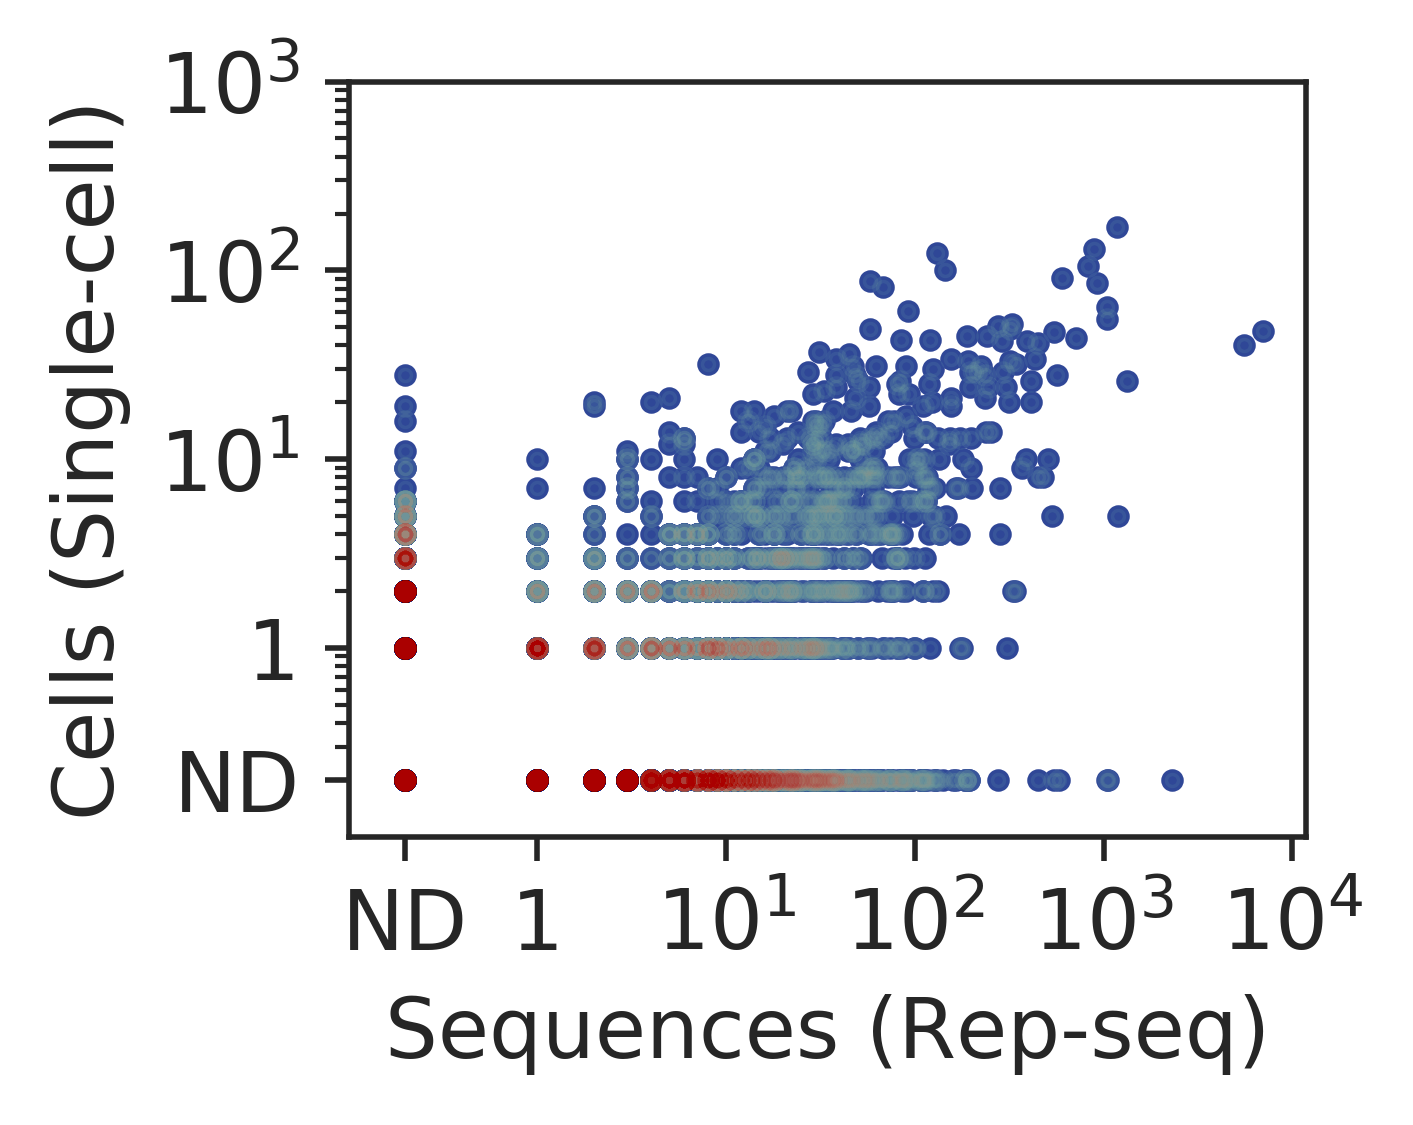

In [9]:
# Plot comparison of methods, pseudocolored by density

clone_dynamics_temp = clone_dynamics.copy(deep=True) # copy data so we don't edit original

pseudocount = 0.2
x = clone_dynamics_temp["sequences_V6"]
y = clone_dynamics_temp["cells_10X"]
x = x.replace(0, pseudocount)
y = y.replace(0, pseudocount)

# plot
fig, ax = plt.subplots(1, 1, figsize=(3,2))
ax.scatter(x, y, alpha=0.01, c="r", zorder=4, s=5, edgecolors=None)
ax.scatter(x, y, alpha=0.05, c="#a1dab4", zorder=3, s=5, edgecolors=None)
ax.scatter(x, y, alpha=0.1, c="#41b6c4", zorder=2, s=5, edgecolors=None)
ax.scatter(x, y, alpha=1, c="#253494", zorder=1, s=5, edgecolors=None)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(left=0.1)
ax.set_ylim(bottom=0.1)

ax.set_xticks([0.2, 1, 10, 1e2, 1e3, 1e4])
ax.set_yticks([0.2, 1, 10, 1e2, 1e3])

ax.set_xticklabels(["ND", "1", "$10^1$", "$10^2$", "$10^3$", "$10^4$"])
ax.set_yticklabels(["ND", "1", "$10^1$", "$10^2$", "$10^3$"])

ax.set_xlabel("Sequences (Rep-seq)")
ax.set_ylabel("Cells (Single-cell)")

ax.set_aspect("equal")

save_figure(fig, "map_counts_cells_sequences")

In [10]:
# Calculate correlation between repertoire and single-cell sequencing

clone_dynamics_temp = clone_dynamics.copy(deep=True) # copy data so we don't edit original

# zeros for not detected
x = clone_dynamics_temp["sequences_V6"]
y = clone_dynamics_temp["cells_10X"]
print("Zeros for not detected")
print(scipy.stats.pearsonr(x, y))
print(scipy.stats.spearmanr(x, y))
print

# pseudocounts for not detected
pseudocount = 0.2
x = clone_dynamics_temp["sequences_V6"]
y = clone_dynamics_temp["cells_10X"]
x = x.replace(0, pseudocount)
y = y.replace(0, pseudocount)
print("Pseudocount for not detected")
print(scipy.stats.pearsonr(x, y))
print(scipy.stats.spearmanr(x, y))
print

# omit not detected
x = clone_dynamics_temp["sequences_V6"]
y = clone_dynamics_temp["cells_10X"]
selector = (x > 0) & (y > 0)
x = x[selector]
y = y[selector]
print("Omit not detected")
print(scipy.stats.pearsonr(x, y))
print(scipy.stats.spearmanr(x, y))
print

Zeros for not detected
(0.3804328138642588, 0.0)
SpearmanrResult(correlation=0.3602095456736577, pvalue=0.0)

Pseudocount for not detected
(0.3805693005309252, 0.0)
SpearmanrResult(correlation=0.3602095456736577, pvalue=0.0)

Omit not detected
(0.3621047518680275, 7.5131460692838215e-34)
SpearmanrResult(correlation=0.5714135108159581, pvalue=5.8112925980552056e-92)



# Identify vaccine-responsive clonal lineages

In [11]:
# Original criterion for Vaccine-responsive (VR) lineages in Horns et al. PNAS 2019
selector = (clone_dynamics["V6_V3_ratio"] > 50) & (clone_dynamics["sequences_V6_normed"] > 0.001) & (clone_dynamics["cells_10X"] > 0) 
clone_dynamics_VR = clone_dynamics.loc[selector].copy(deep=True)
print "Number of vaccine-responsive lineages:", clone_dynamics_VR.shape[0]
clone_dynamics_VR.head()


Number of vaccine-responsive lineages: 5


,sequences_V1,molecules_V1,sequences_V2,molecules_V2,sequences_V3,molecules_V3,sequences_V4,molecules_V4,sequences_V5,molecules_V5,sequences_V6,molecules_V6,sequences_V6_Full,molecules_V6_Full,sequences_V7,molecules_V7,sequences_V8,molecules_V8,patient_uid,sequences_V1_normed,sequences_V2_normed,sequences_V3_normed,sequences_V4_normed,sequences_V5_normed,sequences_V6_normed,sequences_V7_normed,sequences_V8_normed,V3_V1_ratio,onset,V6_V3_ratio,cells_10X
uid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20201010000000001,0.0,0.0,2.0,4.0,1.0,1.0,6.0,59.0,0.0,0.0,7003.0,199802.0,15632.0,75504.0,1101.0,29234.0,307.0,7427.0,2,0.000000,0.000034,0.000019,0.000159,0.000000,0.084574,0.026856,0.005361,inf,1,4364.622308,48
20201010000000267,1.0,3.0,4.0,10.0,0.0,0.0,2.0,5.0,9.0,29.0,5540.0,205166.0,5722.0,29134.0,880.0,30579.0,345.0,11359.0,2,0.000022,0.000068,0.000000,0.000053,0.000189,0.066906,0.021466,0.006024,0.000000,0,inf,40
20201010000042860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,118.0,1681.0,117.0,363.0,26.0,361.0,22.0,289.0,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.001425,0.000634,0.000384,NaN,5,inf,7
20201010000102711,2.0,3.0,3.0,14.0,1.0,1.0,1.0,2.0,2.0,4.0,99.0,4401.0,3.0,5.0,0.0,0.0,2.0,3.0,2,0.000044,0.000051,0.000019,0.000027,0.000042,0.001196,0.000000,0.000035,0.440628,0,61.701786,3
20201010000112385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,99.0,2851.0,57.0,230.0,4.0,10.0,10.0,258.0,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.001196,0.000098,0.000175,NaN,5,inf,1


# Visualize clone dynamics

In [13]:
# Useful plotting parameters and functions

def plot_pretty_time_series(df, labels, N, ax, **kwargs):
#    sns.set_palette(sns.dark_palette(color, n_colors=N, input="rgb", reverse=True))
    for i in range(N):
        x = labels
        y = df.iloc[i] * 100 # convert to percent
#        c = cmap(float(i) / float(N))
        ax.plot(x, y, **kwargs)

In [14]:
# Select data and preprocess (pseudocount for not detected)

columns = ["sequences_V" + str(x) + "_normed" for x in range(1, 9)] # columns to plot
days = [-5, -3, 0, 1, 4, 7, 9, 11] # days of samples (for labeling xticks)

# All lineages
dfx_all = clone_dynamics # subset of clonal lineages that contains single cells
dfx_all = copy.deepcopy(dfx_all) # make a copy of the dataframe so data is not overwritten
dfx_all = dfx_all[columns] # select normalized dynamics
dfx_all[dfx_all == 0.] = 1e-6 # replace 0 values with 1e-6 to show not detected (ND)

# All lineages with single cells mapped
dfx_mapping_matches = clone_dynamics.loc[clone_dynamics["cells_10X"] > 0] # subset of clonal lineages that contains single cells
dfx_mapping_matches = copy.deepcopy(dfx_mapping_matches) # make a copy of the dataframe so data is not overwritten
dfx_mapping_matches = dfx_mapping_matches[columns] # select normalized dynamics
dfx_mapping_matches[dfx_mapping_matches == 0.] = 1e-6 # replace 0 values with 1e-6 to show not detected (ND)

# Vaccine-responsive lineages
dfx_VR = copy.deepcopy(clone_dynamics_VR) # make a copy of the dataframe so data is not overwritten
dfx_VR = dfx_VR[columns] # select normalized dynamics
dfx_VR[dfx_VR == 0.] = 1e-6 # replace 0 values with 1e-6 to show not detected (ND)


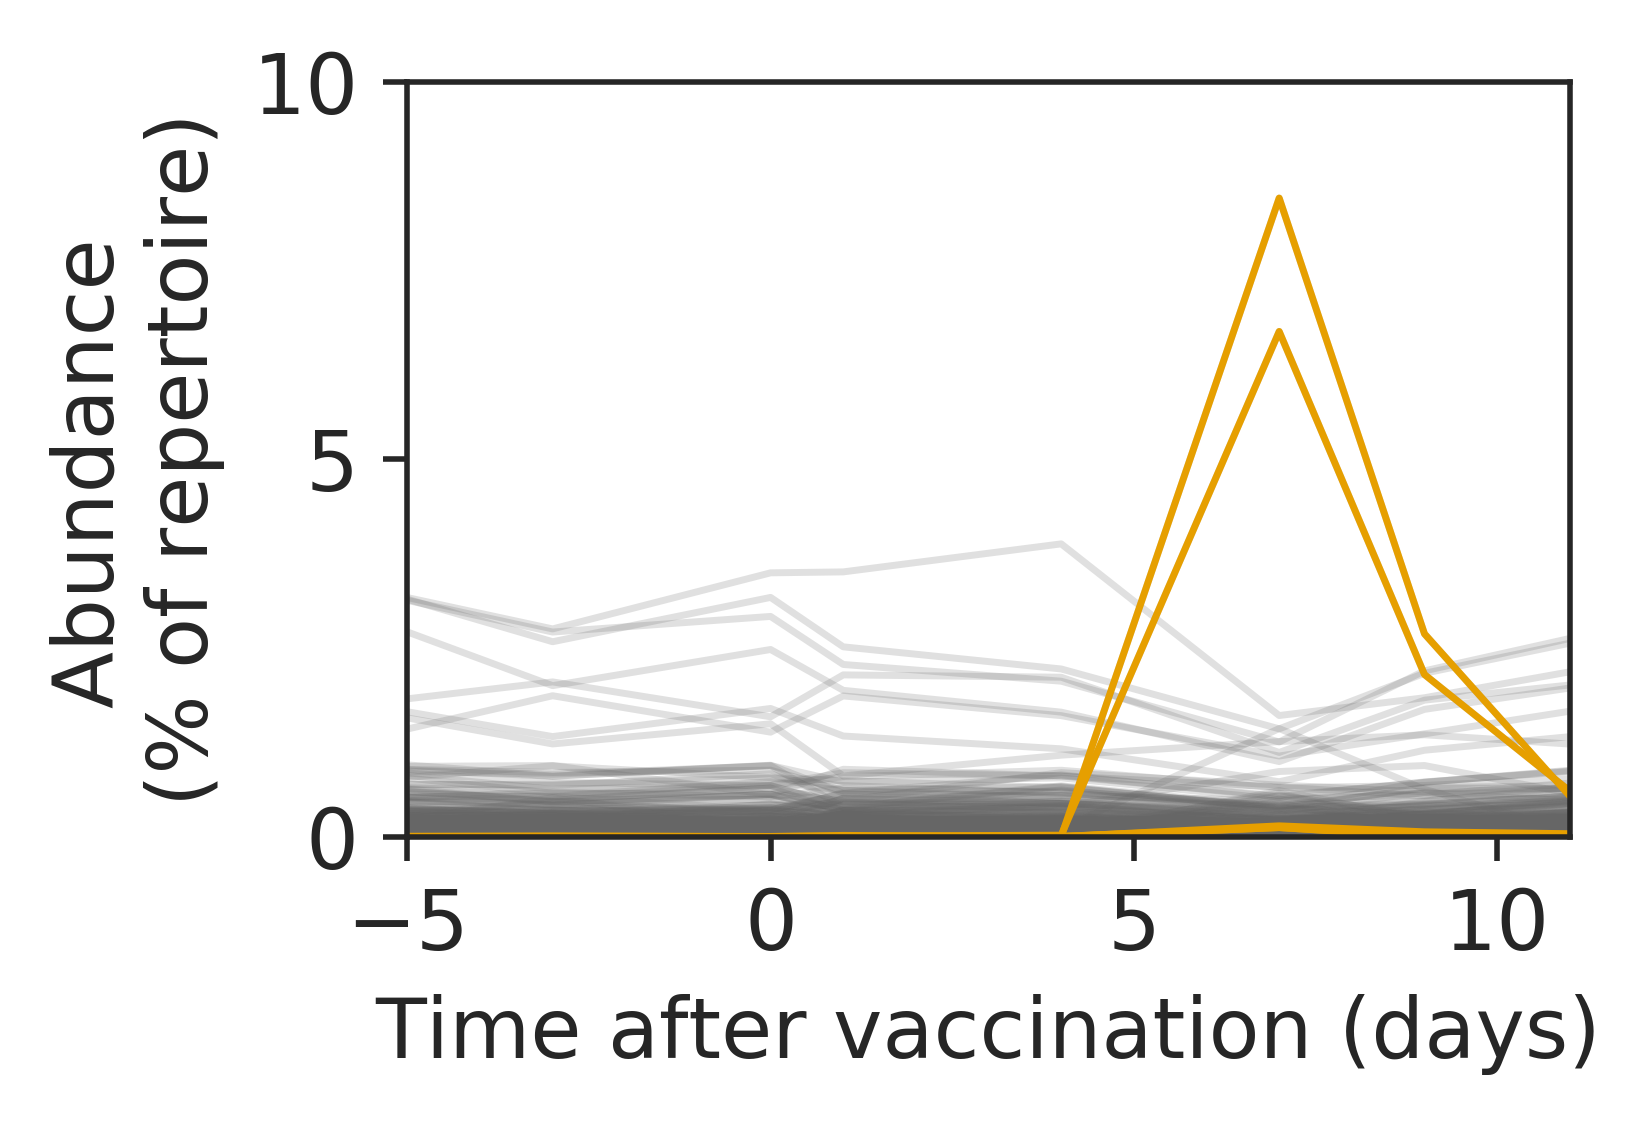

In [15]:
# Plot dynamics (linear scale)

fig, ax = plt.subplots(1, 1, figsize=(3,2))

plot_pretty_time_series(dfx_mapping_matches, days, N=dfx_mapping_matches.shape[0], ax=ax, marker="", markersize=2, lw=1, color="#666666", alpha=0.2, zorder=1)
plot_pretty_time_series(dfx_VR, days, N=dfx_VR.shape[0], ax=ax, marker="", markersize=2, lw=1, color="#E69F00", alpha=1, zorder=2)

ax.set_ylim([0, 10])
ax.set_xlim(-5,11)
ax.set_xlabel("Time after vaccination (days)")
ax.set_ylabel("Abundance \n(% of repertoire)")
ax.set_xticks([-5, 0, 5, 10])
ax.set_yticks([0, 5, 10])

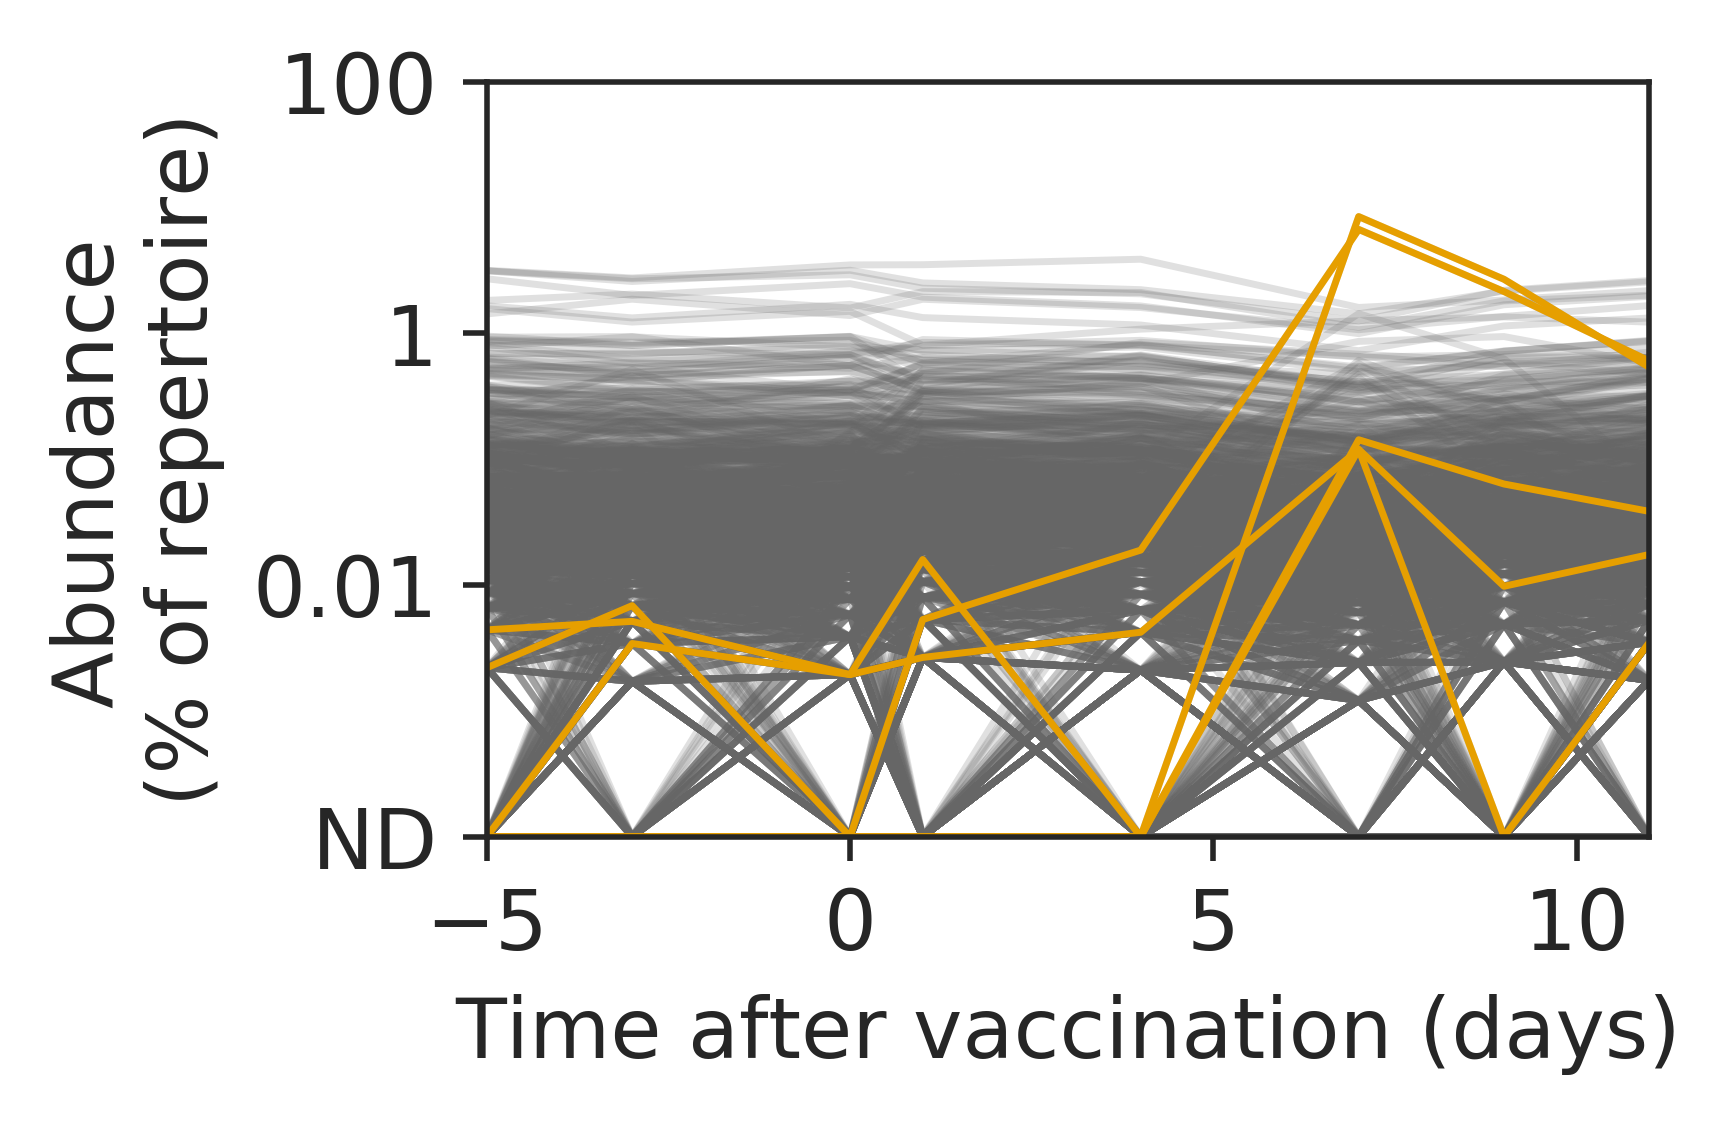

In [16]:
# Plot dynamics (log scale)

fig, ax = plt.subplots(1, 1, figsize=(3,2))

plot_pretty_time_series(dfx_mapping_matches, days, N=dfx_mapping_matches.shape[0], ax=ax, marker="", markersize=2, lw=1, color="#666666", alpha=0.2, zorder=1)
# plot_pretty_time_series(dfx_all, days, N=20, ax=ax, marker="", markersize=2, lw=1, color="#666666", alpha=0.2, zorder=1) # plot only a few to speed up plotting for testing
plot_pretty_time_series(dfx_VR, days, N=dfx_VR.shape[0], ax=ax, marker="", markersize=2, lw=1, color="#E69F00", alpha=1, zorder=2)

ax.set_yscale("log")
ax.set_ylim([1e-4, 100])
ax.set_xlim(-5,11)
ax.set_xlabel("Time after vaccination (days)")
ax.set_ylabel("Abundance \n(% of repertoire)")
ax.set_xticks([-5, 0, 5, 10])
ax.set_yticks([1e-4, 1e-2, 1, 100])
ax.set_yticklabels(["ND", "0.01", "1", "100"])

save_figure(fig, "clone_dynamics_VR")

# Visualize expansion versus cells detected 

Text(0,0.5,'Cells')

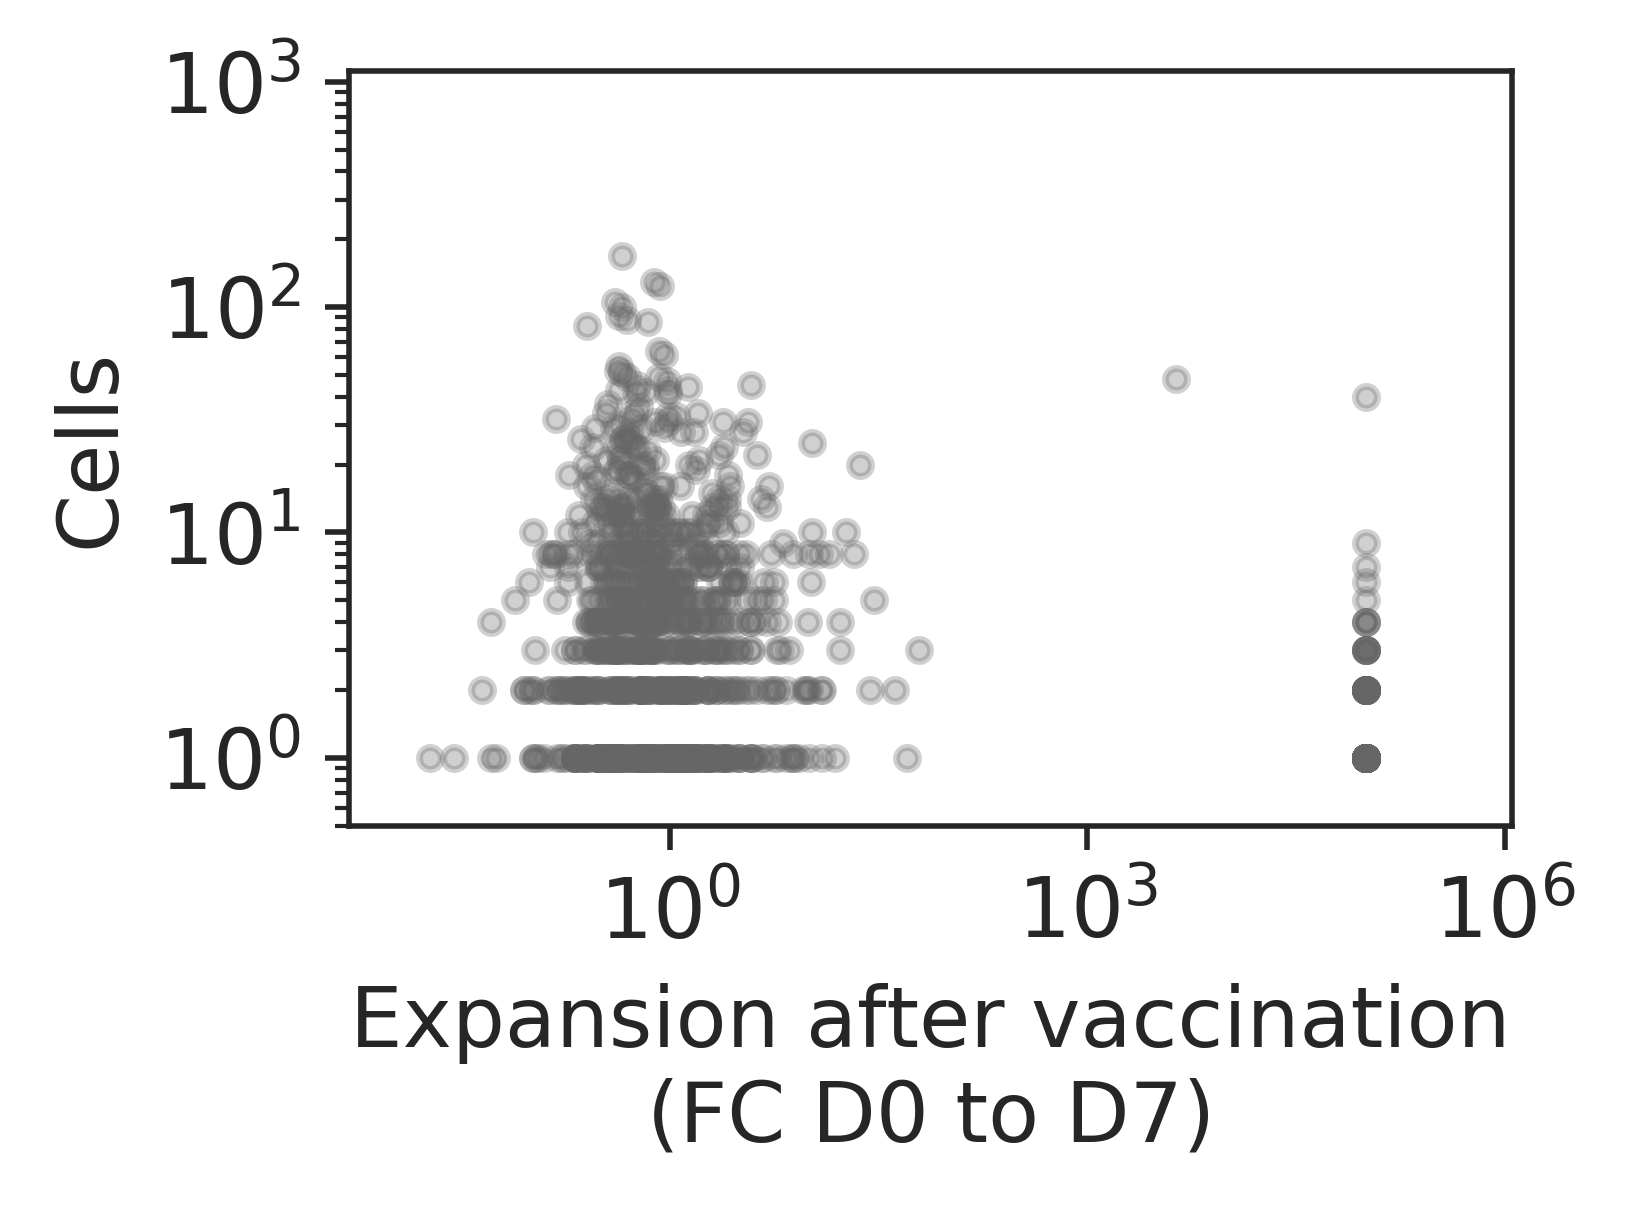

In [17]:
# Expansion after vaccination versus cells detected

clone_dynamics_temp = clone_dynamics.copy(deep=True) # copy data so we don't edit original
pseudocount = 0.2
x = clone_dynamics_temp["V6_V3_ratio"]
y = clone_dynamics_temp["cells_10X"]
x = x.replace(np.inf, 1e5)

# plot
fig, ax = plt.subplots(1, 1, figsize=(3,2))

ax.scatter(x, y, alpha=0.3, c="#666666", label="Other", zorder=0, s=10)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(left=0.005)
ax.set_ylim(bottom=0.5)

# ax.set_xticklabels(["", "", "ND", 1, 10, 100, 1000, 10000])
# ax.set_yticklabels(["", "", "ND", 1, 10, 100])

ax.set_xlabel("Expansion after vaccination\n(FC D0 to D7)")
ax.set_ylabel("Cells")

Text(0,0.5,'Cells')

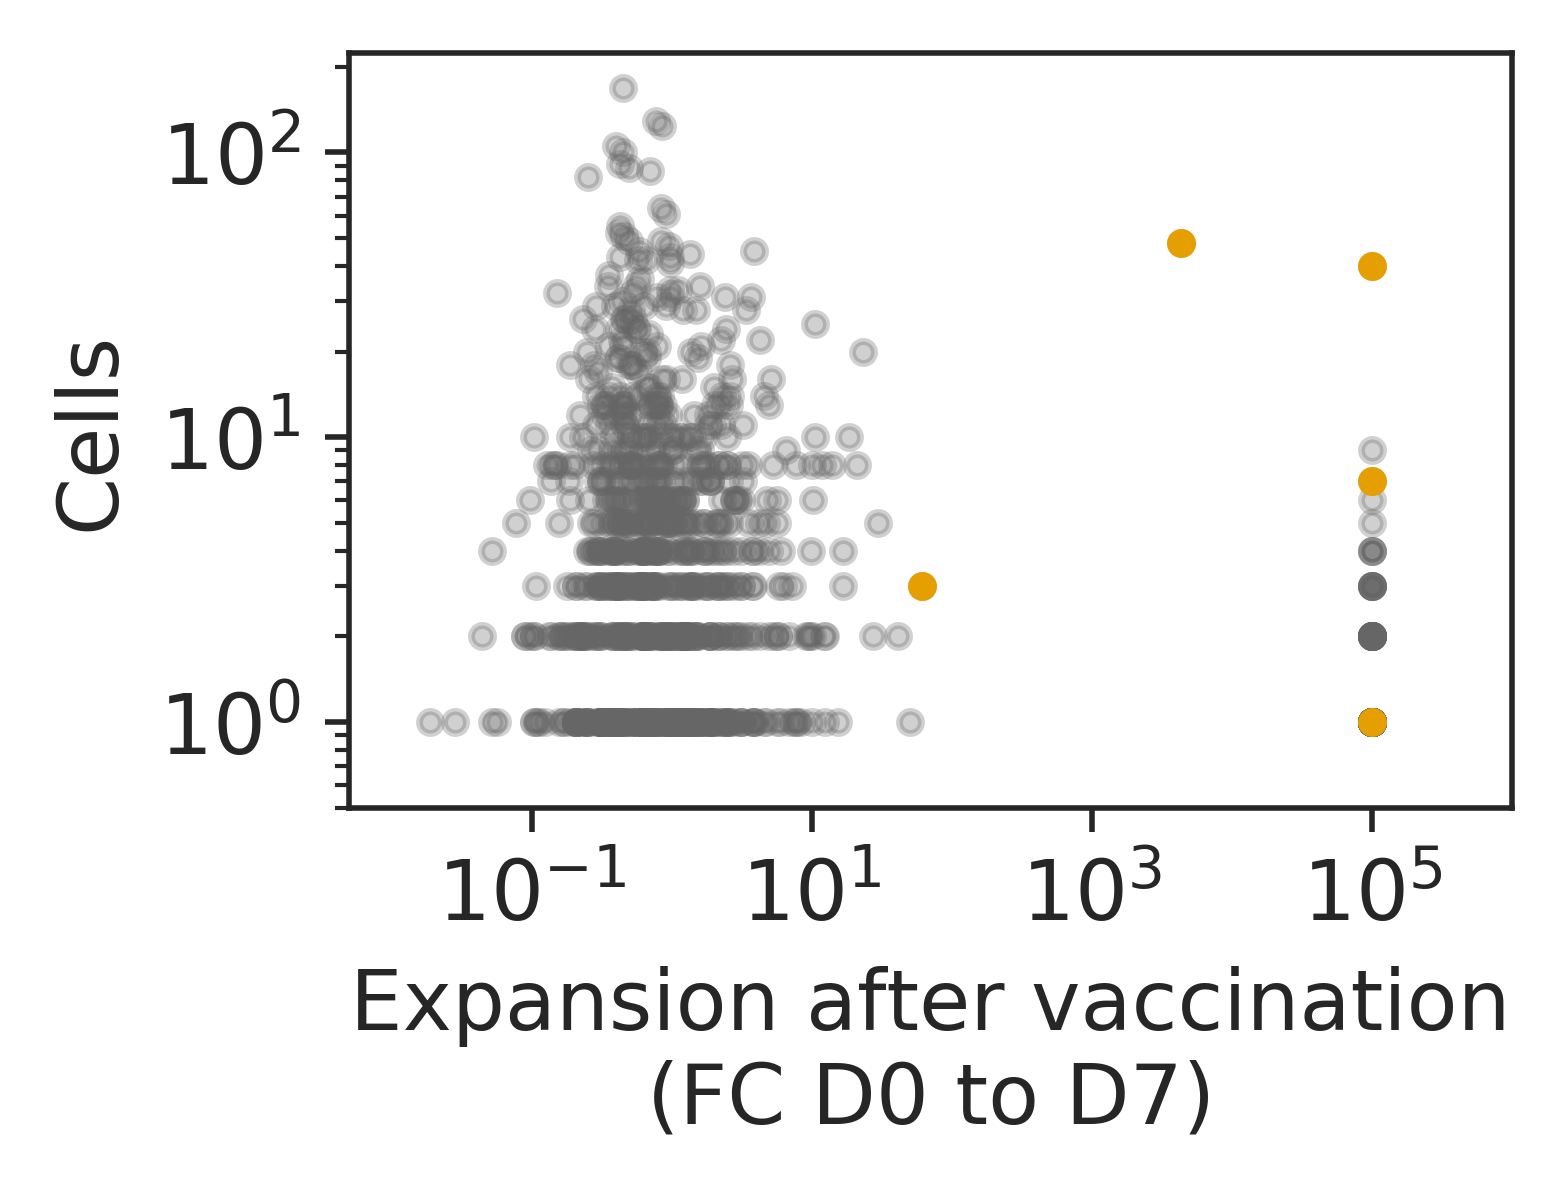

In [18]:
# Expansion after vaccination versus cells detected

clone_dynamics_temp = clone_dynamics.copy(deep=True) # copy data so we don't edit original
pseudocount = 0.2
x = clone_dynamics_temp["V6_V3_ratio"]
y = clone_dynamics_temp["cells_10X"]
x = x.replace(np.inf, 1e5)

clone_dynamics_temp = clone_dynamics_VR.copy(deep=True) # copy data so we don't edit original
pseudocount = 0.2
x2 = clone_dynamics_temp["V6_V3_ratio"]
y2 = clone_dynamics_temp["cells_10X"]
x2 = x2.replace(np.inf, 1e5)

# plot
fig, ax = plt.subplots(1, 1, figsize=(3,2))

ax.scatter(x, y, alpha=0.3, c="#666666", label="Other", zorder=0, s=10)
ax.scatter(x2, y2, alpha=1, c="#E69F00", label="Other", zorder=1, s=10)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(left=0.005, right=1e6)
ax.set_ylim(bottom=0.5)

# ax.set_xticklabels(["", "", "ND", 1, 10, 100, 1000, 10000])
# ax.set_yticklabels(["", "", "ND", 1, 10, 100])

ax.set_xlabel("Expansion after vaccination\n(FC D0 to D7)")
ax.set_ylabel("Cells")

# Visualize degree of clonal expansion in vaccine-responsive and other clones

(-5.0, 3.639946669085261)


/scratch/resources/anaconda2/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0,0.5,'Clones')

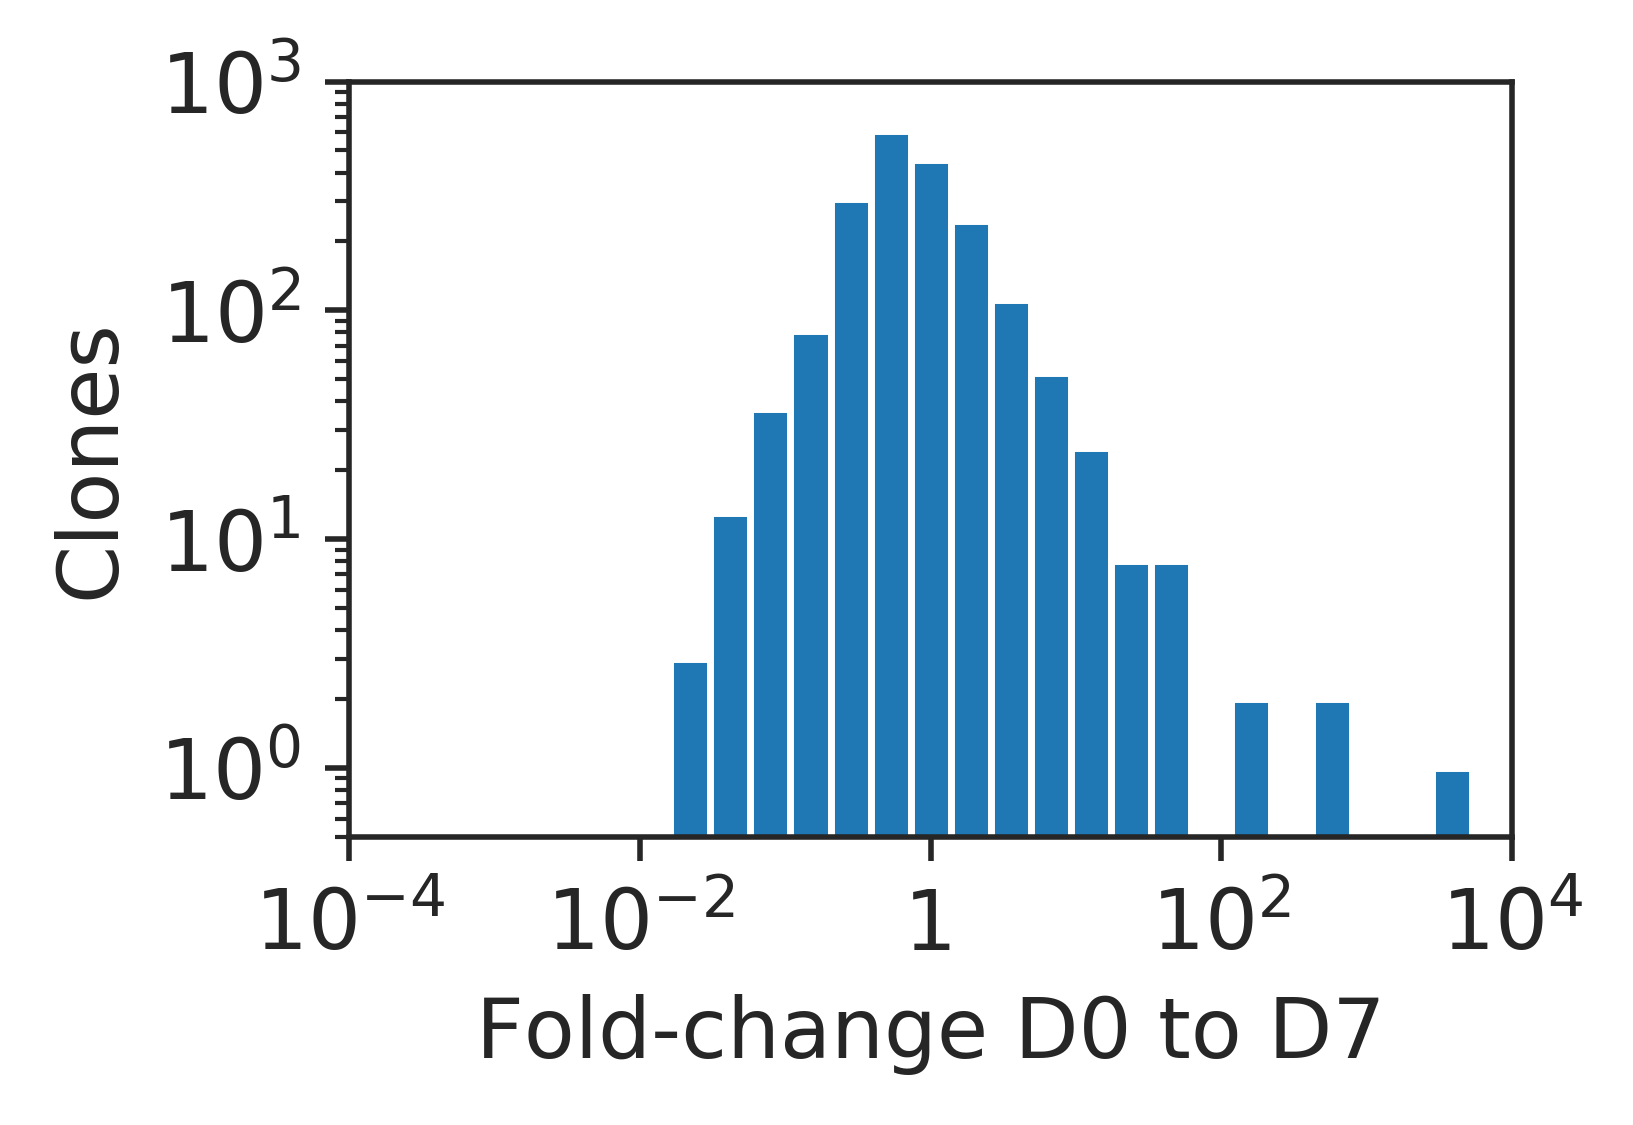

In [19]:
data = clone_dynamics["V6_V3_ratio"].copy(deep=True)
data = data.replace(np.inf, np.nan)
data = np.log10(data + 0.00001)

bins = np.linspace(-4, 4, 30)

print(min(data), max(data))

fig, ax = plt.subplots(1, 1, figsize=(3,2))
ax.hist(data, bins=bins)
ax.set_xlim(-4,4)
ax.set_xticklabels(['$10^{-4}$', '$10^{-2}$', '1', '$10^2$', '$10^4$'])
ax.set_yscale("log")
ax.set_ylim(0.5, 1e3)
ax.set_xlabel("Fold-change D0 to D7")
ax.set_ylabel("Clones")

(-0.636507384214874, 1.617484187045307)


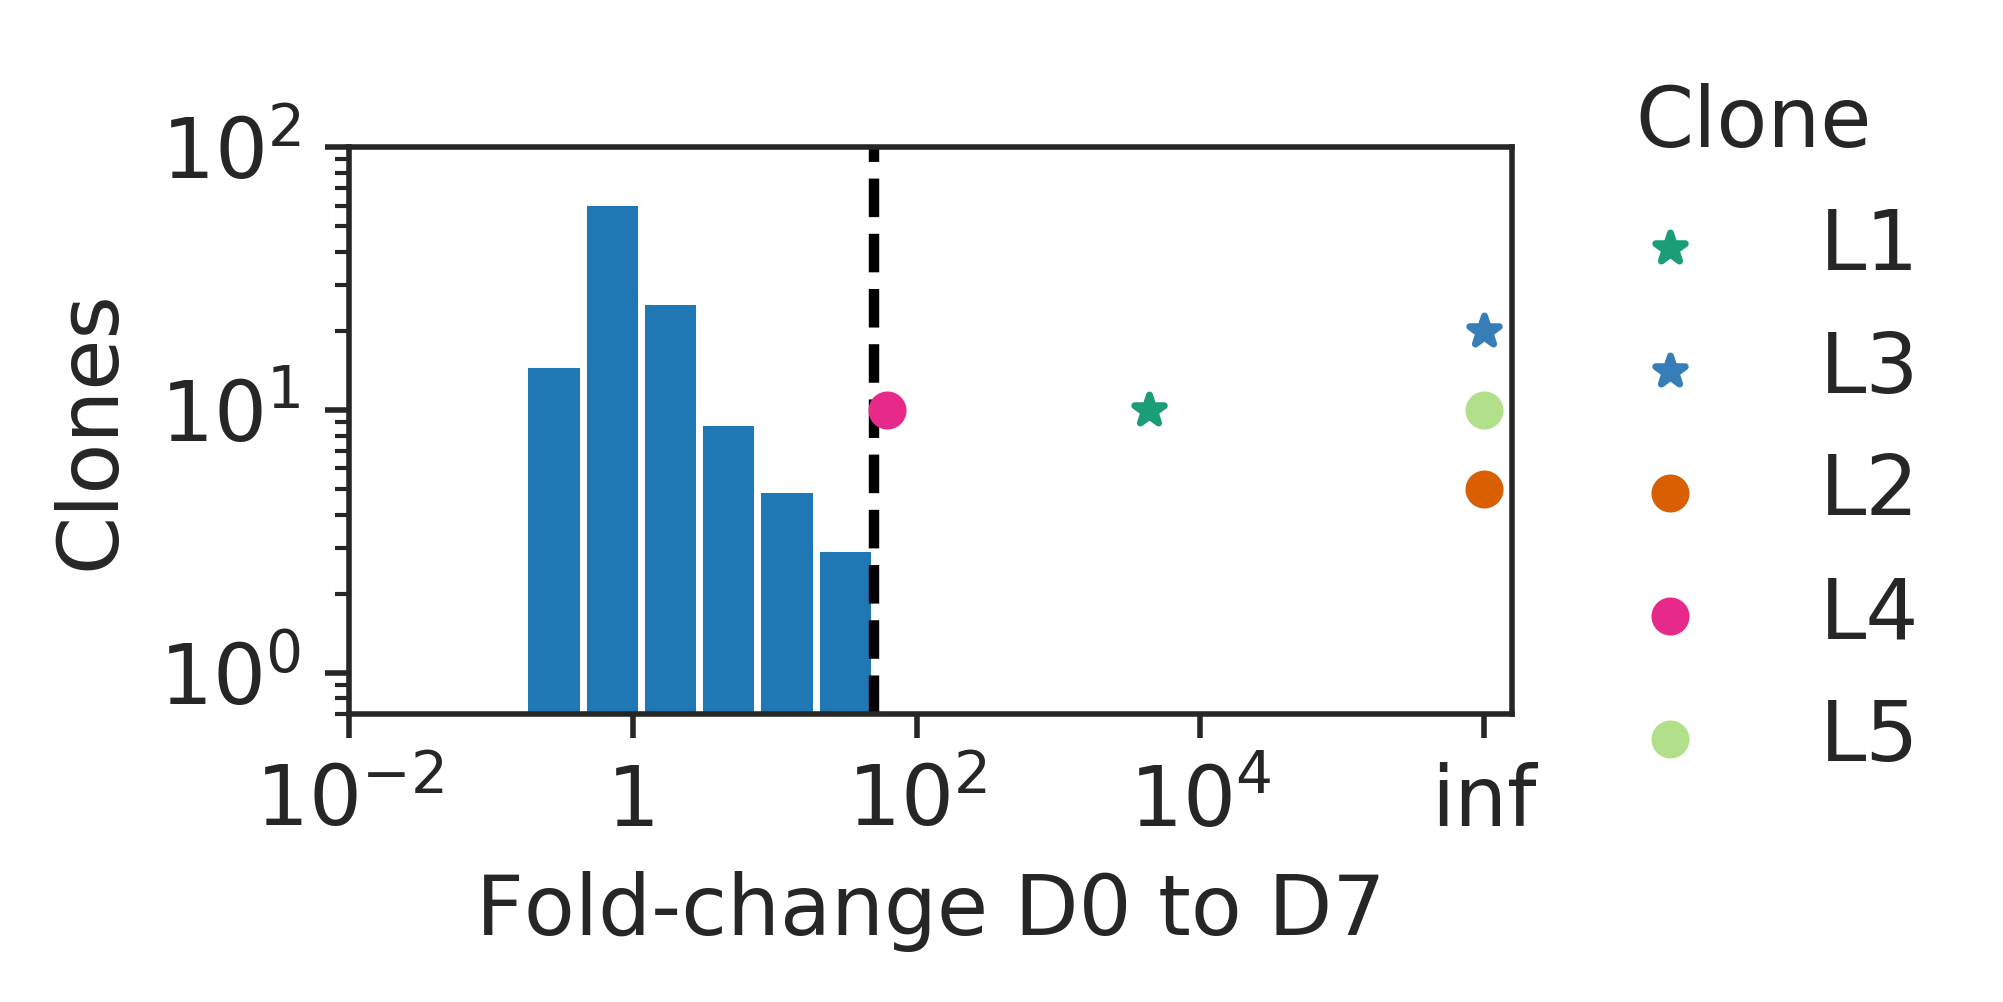

In [20]:
selector = (clone_dynamics["V6_V3_ratio"] <= 50) & (clone_dynamics["sequences_V6_normed"] > 0.001) & (clone_dynamics["cells_10X"] > 0)
data = clone_dynamics.loc[selector]["V6_V3_ratio"].copy(deep=True)
data = np.log10(data)
print(min(data), max(data))

bins = np.linspace(-2, np.log10(50), 10)

fig, ax = plt.subplots(1, 1, figsize=(3,1.5))
ax.hist(data, bins=bins,  label="")
ax.set_xlim(-2,6.2)
ax.set_xticks(np.log10(np.array([1e-2, 1, 1e2, 1e4, 1e6])))
ax.set_xticklabels(['$10^{-2}$', '1', '$10^2$', '$10^4$', 'inf'])
ax.set_yscale("log")
ax.set_ylim(0.7, 1e2)
ax.set_xlabel("Fold-change D0 to D7")
ax.set_ylabel("Clones")
ax.axvline(np.log10(50), ls="--", c="k")

# Show individual vaccine-responsive lineages

data_VR = np.log10(clone_dynamics_VR["V6_V3_ratio"])
data_VR = data_VR.replace(np.inf, 6.0)

palette = ['#1b9e77','#d95f02','#377eb8','#e7298a', "#b2df8a", "#999999"]

x_temp = data_VR.loc[20201010000000001]
y_temp = 10
ax.scatter(x_temp, y_temp, s=20, c=palette[0], zorder=10, label="L1", marker="*")

x_temp = data_VR.loc[20201010000042860]
y_temp = 20
ax.scatter(x_temp, y_temp, s=20, c=palette[2], zorder=10, label="L3", marker="*")

x_temp = data_VR.loc[20201010000000267]
y_temp = 5
ax.scatter(x_temp, y_temp, s=20, c=palette[1], zorder=10, label="L2")

x_temp = data_VR.loc[20201010000102711]
y_temp = 10
ax.scatter(x_temp, y_temp, s=20, c=palette[3], zorder=10, label="L4")

x_temp = data_VR.loc[20201010000112385]
y_temp = 10
ax.scatter(x_temp, y_temp, s=20, c=palette[4], zorder=10, label="L5")

ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), frameon=False, title="Clone")

save_figure(fig, "Dynamics_VR_nonVR")

# Examine basic features of vaccine-responsive clonal lineages (V, J gene use, CDR3 sequence)

In [21]:
# Filter for cells within clones
cells_mapping_matches_VR = cells_mapping_matches.loc[cells_mapping_matches["subject_lineage_uid"].isin(map(str, list(dfx_VR.index)))]
print cells_mapping_matches_VR.shape[0], "cells"
cells_mapping_matches_VR.head()

99 cells


,sample,barcode,is_cell,contig_id,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,full_length,productive,cdr3,cdr3_nt,reads,umis,raw_clonotype_id,raw_consensus_id,len_CDR3_adj,seq_before_CDR3,seq_CDR3_adj,seq_after_CDR3,num_hits,subject_seq_id,subject_lineage_uid,subject_lineage_num_unique_seqs,subject_lineage_num_molecules,subject_V_gene,subject_D_gene,subject_J_gene,subject_isotype,subject_abundance,subject_V_seq,subject_D_seq,subject_J_seq,subject_C_seq,subject_identity_CDR3,subject_identity_non_CDR3,subject_identity_V,subject_identity_J,subject_is_hit,subject2_seq_id,subject2_lineage_uid,subject2_lineage_num_unique_seqs,subject2_lineage_num_molecules,subject2_V_gene,subject2_D_gene,subject2_J_gene,subject2_isotype,subject2_abundance,subject2_V_seq,subject2_D_seq,subject2_J_seq,subject2_C_seq,subject2_identity_CDR3,subject2_identity_non_CDR3,subject2_identity_V,subject2_identity_J,subject2_is_hit
266,023-002_D9_Lane3,AGGCCACGTACTCAAC-1,True,AGGCCACGTACTCAAC-1_contig_2,True,692,IGH,IGHV3-15,IGHD2-21,IGHJ5,IGHG3,True,True,CKSLLTTIPERWFDPW,TGTAAGTCTCTACTGACTACTATTCCGGAAAGGTGGTTCGACCCCTGG,3226,4,clonotype967,clonotype967_consensus_2,41,GGGAGCTCTGGGAGAGGAGCCCCAGCCTTGGGATTCCCAAGTGTTT...,AAGTCTCTACTGACTACTATTCCGGAAAGGTGGTTCGACCC,CTGGGGCCAGGGAACCCTAGTCAGCGTCTCCTCAGCCTCCACCAAG...,8727,20602010100012605,20201010000000001,24053.0,312032.0,IGHV3-15*01,IGHD2-21*02,IGHJ5*02,IgG,"3,3",TCTGCAAATGAACAGCCTGAAAATCGAGGACACAGCCGTCTACTATTGT,AAGTCTCTACTGACTACTATTCCGGAAAGGTGGTTCGACCC,CTGGGGCCAGGGAACCCTAGTCAGCGTCTCCTCA,GCCTCCACCAAGGGCCATCGGTCTT,1.0,1.000000,1.000000,1.000000,True,20602010100024374,20201010000000001,24053.0,312032.0,IGHV3-15*01,IGHD2-21*02,IGHJ5*02,IgG,4,TCTGCAAATGAACAGCCTGAAAATCGAGGACACAGCCGTCTACTATTGT,AAGTCTCTACTGACTACTATTCCGGAAAGGTGGTTCGACCC,CTGGGGCCAGGGAACCCTAGTCAGCGTCTCCTCA,GCCTCCACCAAGGGCCCACCGGTCTT,1.000000,1.000000,1.000000,1.000000,True
1421,023-002_D9_Lane3,TACCTATCAGCCAGAA-1,True,TACCTATCAGCCAGAA-1_contig_2,True,549,IGH,IGHV1-3,IGHD6-19,IGHJ6,IGHM,True,True,CARGWYFNYNYYYMDVW,TGTGCGAGGGGCTGGTACTTCAACTACAACTACTACTACATGGACG...,3580,7,clonotype4851,clonotype4851_consensus_2,44,GGGACCCAACAATCACATCCCTCCTCAGAAGCCCCCAGAGCACAAC...,GCGAGGGGCTGGTACTTCAACTACAACTACTACTACATGGACGT,CTGGGGCAAAGGGACCACGGTCACCGTCTCCTCAGGGAGTGCATCC...,1,29902010100343953,20201010000102711,114.0,4435.0,IGHV1-3*01,IGHD6-19*01,IGHJ6*03,IgM,2,TGCAGTCTGGGGCTGAGGTGAAGAAGCCTGGGGCCTCAGTGAAGGT...,GCGAGGGGCTGGTACTTCAACTACAACTACTACTACATGGACGT,CTGGGGCAAAGGGACCACGGTCACCGTCTCCTC,AGGGAGTGCATCCGCCCCAACCCTTTTCCCCCTCGTCTCCTGTGAG...,1.0,0.970779,0.967273,1.000000,True,20802010100011970,20201010000102711,114.0,4435.0,IGHV1-3*01,IGHD3-10*01,IGHJ6*03,IgA,2,AGCCTACATGGAGCTGAGCAGTCTGAGATCTGAAGACACGGCTGTG...,GCGAGGGCGGGGAGTTACTACTCCTACAACTACTACATGGACGT,CTGGGGCAAAGGGACCACGGTCACCGTCTCCTC,AGCATCCCCGACCAGCCCCAAGGTCTTC,0.795455,0.943182,0.909091,1.000000,False
1672,023-002_D9_Lane3,TCTTTCCTCTTCAACT-1,True,TCTTTCCTCTTCAACT-1_contig_1,True,647,IGH,IGHV4-59,IGHD3-10,IGHJ4,IGHG3,True,True,CARLNMVRGEFWGYYFDYW,TGTGCGAGACTTAATATGGTTCGGGGAGAATTTTGGGGGTACTACT...,1835,4,clonotype5425,clonotype5425_consensus_2,50,GGGACTTTCTGAGAGTCCTGGACCTCCTGTGCAAGAACATGAAACA...,GCGAGACTTAATATGGTTCGGGGAGAATTTTGGGGGTACTACTTTG...,CTGGGGCCAGGGAGCCCTGGTCACTGTCTCCTCAGCCTCCACCAAG...,7879,20602010100196131,20201010000000267,12504.0,276287.0,IGHV4-59*08,IGHD3-10*01,IGHJ4*02,IgG,"7,3",TTCTCCCTGAAGCTGCGCTCTGTGGCCGCCGCAGACACGGCCGTGT...,GCGAGACTTAATATGGTTCGGGGAGAATTTTGGGGGTACTACTTTG...,CTGGGGCCAGGGAGCCCTGGTCACTGTCTCCTCA,GCCTCCACCAAGGGCCCATCGGTCTT,1.0,1.000000,1.000000,1.000000,True,20702010100083461,20201010000000267,12504.0,276287.0,IGHV4-59*08,IGHD3-10*01,IGHJ4*02,IgG,"7,3",TTCTCCCTGAAGCTGCGCTCTGTGGCCGCCGCAGACACGGCCGTGT...,GCGAGACTTAATATGGTTCGGGGAGAATTTTGGGGGTACTACTTTG...,CTGGGGCCAGGGAGCCCTGGTCACTGTCTCCTCA,GCCTCCACCAAGGGCCCATCGGTCTT,1.000000,1.000000,1.000000,1.000000,True
1688,023-002_D9_Lane3,ATTACTCAGCGTTTAC-1,True,ATTACTCAGCGTTTAC-1_contig_5,True,706,IGH,IGHV3-15,IGHD2-21,IGHJ5,IGHG2,True,True,CKSLLTTIPEKWFDPW,T

In [22]:
# Keep only 1 representative of each lineage, view desired attributes
columns = ["subject_lineage_uid", "v_gene", "j_gene", "c_gene", "cdr3"]
dfx_temp = cells_mapping_matches_VR.drop_duplicates(subset="subject_lineage_uid")[columns].sort_values(by="subject_lineage_uid")
dfx_temp

,subject_lineage_uid,v_gene,j_gene,c_gene,cdr3
266,20201010000000001,IGHV3-15,IGHJ5,IGHG3,CKSLLTTIPERWFDPW
1672,20201010000000267,IGHV4-59,IGHJ4,IGHG3,CARLNMVRGEFWGYYFDYW
6003,20201010000042860,IGHV4-34,IGHJ3,IGHG1,CARHFQERLGAARAGAFDVW
1421,20201010000102711,IGHV1-3,IGHJ6,IGHM,CARGWYFNYNYYYMDVW
90860,20201010000112385,IGHV4-59,IGHJ4,IGHG2,CARLNMVRGELWGFHFDYW


In [23]:
# Examine CDR3 lengths
print("CDR3 lengths")
print([len(x) for x in dfx_temp["cdr3"]])

CDR3 lengths
[16, 19, 20, 17, 19]


In [25]:
# Report features of sequences in VR lineages

# Select sequence annotations for VR lineages
selector = rep_seq_annot["lineage_uid"].isin(set(dfx_temp["subject_lineage_uid"]))
rep_seq_annot_VR = rep_seq_annot.loc[selector]

print "Class"
print rep_seq_annot_VR.groupby("lineage_uid")["class"].value_counts(normalize=True)
print "Mean IgG", rep_seq_annot_VR.groupby("lineage_uid")["class"].value_counts(normalize=True).xs("IgG", level=1).mean()
print "STD IgG", rep_seq_annot_VR.groupby("lineage_uid")["class"].value_counts(normalize=True).xs("IgG", level=1).std()
print

print "Mutation density"
print rep_seq_annot_VR.groupby("lineage_uid")["mut_density"].mean()
print "Mean", rep_seq_annot_VR.groupby("lineage_uid")["mut_density"].mean().mean()
print "STD", rep_seq_annot_VR.groupby("lineage_uid")["mut_density"].mean().std()
print

print "V germline identity"
print rep_seq_annot_VR.groupby("lineage_uid")["V_germline_identity"].mean()
print "Mean", rep_seq_annot_VR.groupby("lineage_uid")["V_germline_identity"].mean().mean()
print


Class
lineage_uid        class
20201010000000001  IgG      0.951607
                   IgA      0.027439
                   IgE      0.011724
                   IgM      0.007317
                   IgD      0.001912
20201010000000267  IgG      0.974248
                   IgA      0.016795
                   IgM      0.005598
                   IgD      0.002559
                   IgE      0.000800
20201010000042860  IgG      0.947183
                   IgA      0.049296
                   IgE      0.003521
20201010000102711  IgG      0.842105
                   IgA      0.078947
                   IgD      0.026316
                   IgE      0.026316
                   IgM      0.026316
20201010000112385  IgG      1.000000
Name: class, dtype: float64
Mean IgG 0.9430286940957193
STD IgG 0.06020127248950435

Mutation density
lineage_uid
20201010000000001    0.058905
20201010000000267    0.032112
20201010000042860    0.045265
20201010000102711    0.024721
20201010000112385    0.031045
Na

class,IgM,IgD,IgG,IgA,IgE
lineage_uid,,,,,
20201010000000001,0.731717,0.191244,95.160687,2.743940,1.172411
20201010000000267,0.559821,0.255918,97.424824,1.679463,0.079974
20201010000042860,0.000000,0.000000,94.718310,4.929577,0.352113
20201010000102711,2.631579,2.631579,84.210526,7.894737,2.631579
20201010000112385,0.000000,0.000000,100.000000,0.000000,0.000000
Unmutated,79.111214,2.548648,5.273766,5.210369,7.856004
Mutated,40.105168,0.842940,34.157531,22.606381,2.287980


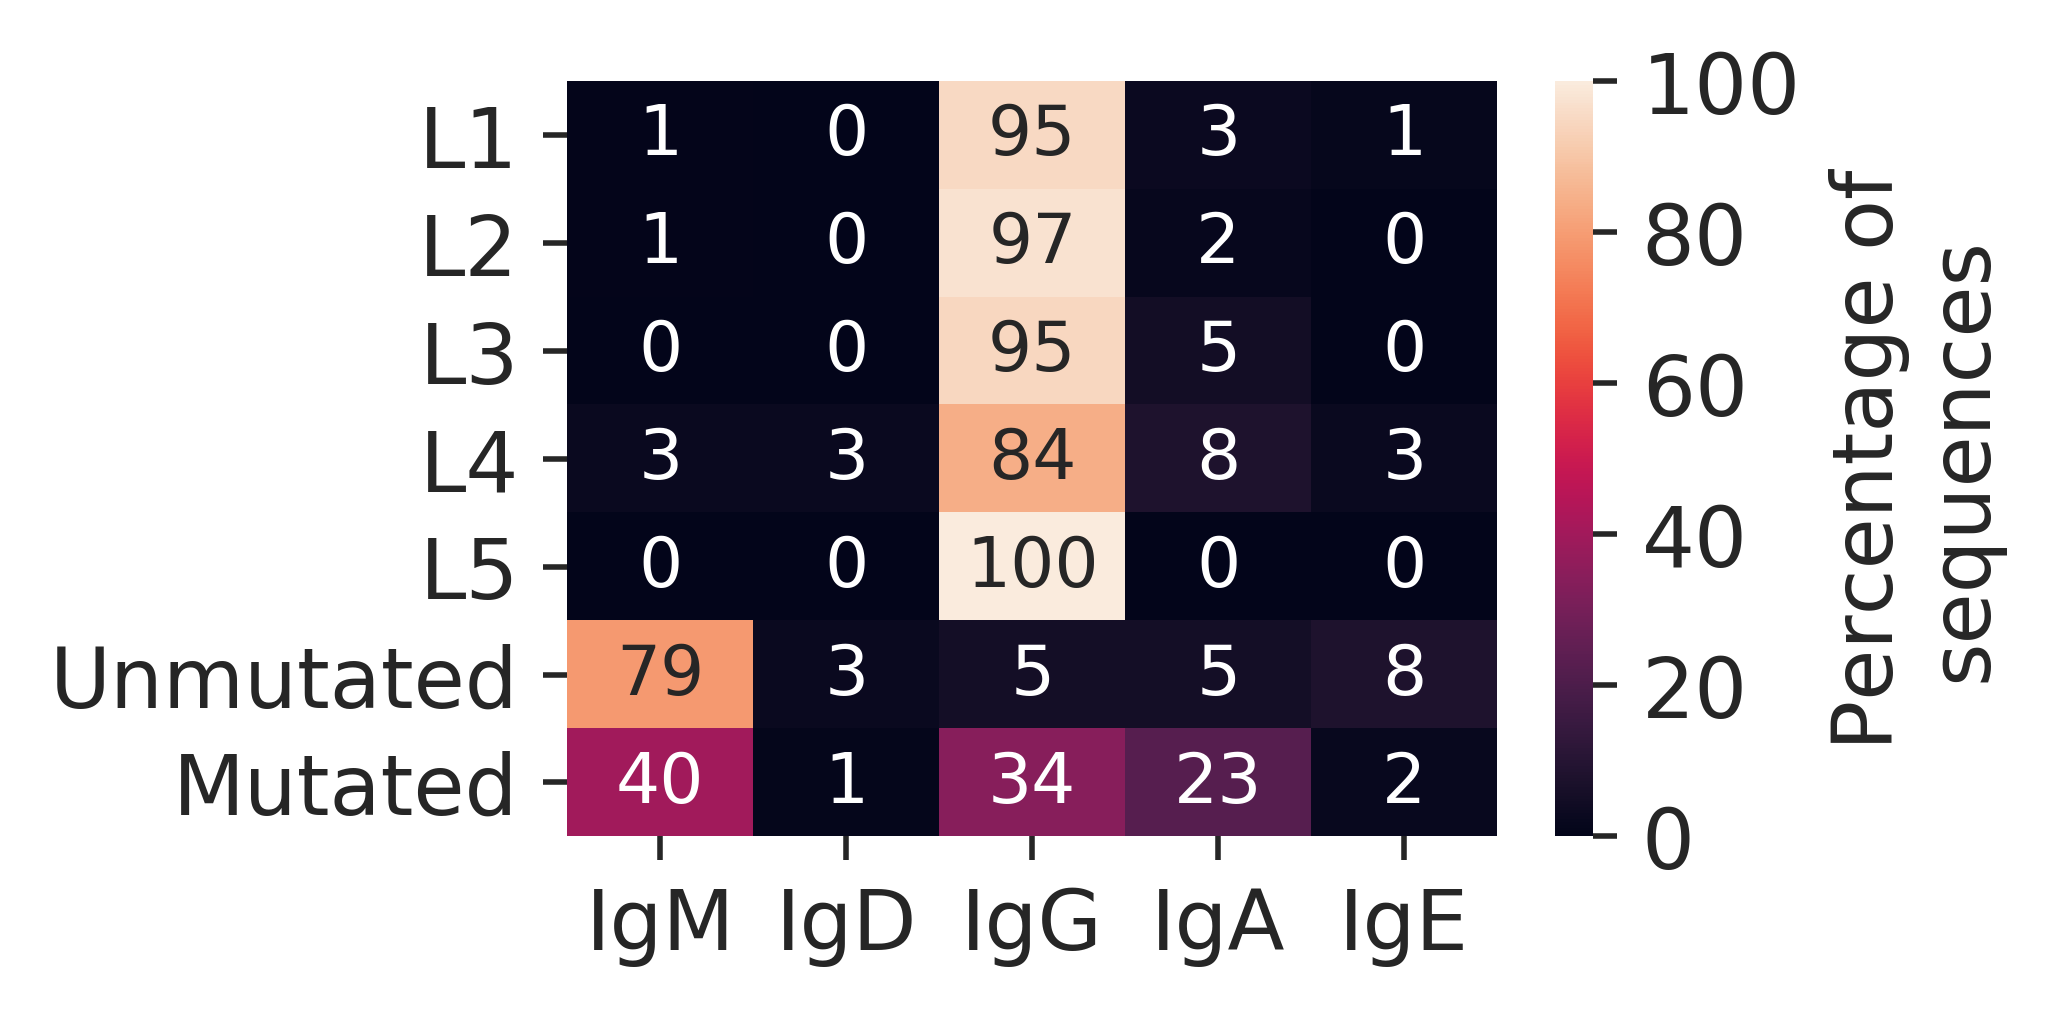

In [26]:
# Make plot of isotypes in vaccine-responsive lineages and memory repertoire
data = pd.DataFrame(rep_seq_annot_VR.groupby("lineage_uid")["class"].value_counts(normalize=True)).unstack()
data.columns = data.columns.droplevel(level=None)
columns = ["IgM", "IgD", "IgG", "IgA", "IgE"]
data = data[columns]


row = rep_seq_annot.loc[rep_seq_annot["V_germline_identity"] == 1.0]["class"].value_counts(normalize=True)
data = data.append(row)
data = data.rename(index={"class": "Unmutated"})

row = rep_seq_annot.loc[rep_seq_annot["V_germline_identity"] < 1.0]["class"].value_counts(normalize=True)
data = data.append(row)
data = data.rename(index={"class": "Mutated"})

data = data.fillna(value=0)
data = data * 100 # convert to percent

fig, ax = plt.subplots(1, 1, figsize=(3,2))
sns.heatmap(data=data, ax=ax, annot=True, fmt=".0f", annot_kws={"size": 10}, cbar_kws={"label": "Percentage of\nsequences"})
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_yticklabels(["L1", "L2", "L3", "L4", "L5", "Unmutated", "Mutated"])

save_figure(fig, "heatmap_isotypes_clones")

data

In [27]:
# Report percentage IgG
print(np.mean(data["IgG"].iloc[0:5]), np.std(data["IgG"].iloc[0:5]))

(94.30286940957194, 5.384565504740791)


In [28]:
# Report subclass annotations of single cells from VR clones
cells_mapping_matches_VR["c_gene"].value_counts(normalize=True)

IGHG1    0.484848
IGHG2    0.222222
IGHG3    0.090909
IGHA1    0.090909
IGHM     0.070707
None     0.040404
Name: c_gene, dtype: float64

In [29]:
cells_mapping_matches_VR.groupby("subject_lineage_uid")["c_gene"].value_counts(normalize=True)

subject_lineage_uid  c_gene
20201010000000001    IGHG1     0.458333
                     IGHG2     0.208333
                     IGHA1     0.125000
                     IGHG3     0.083333
                     IGHM      0.062500
                     None      0.062500
20201010000000267    IGHG1     0.575000
                     IGHG2     0.175000
                     IGHG3     0.125000
                     IGHA1     0.075000
                     IGHM      0.025000
                     None      0.025000
20201010000042860    IGHG2     0.571429
                     IGHG1     0.428571
20201010000102711    IGHM      1.000000
20201010000112385    IGHG2     1.000000
Name: c_gene, dtype: float64

In [30]:
# Calculate means per lineage
print "IGHG1", np.sum(cells_mapping_matches_VR.groupby("subject_lineage_uid")["c_gene"].value_counts(normalize=True).xs("IGHG1", level=1))/5
print "IGHG1", np.sum(cells_mapping_matches_VR.groupby("subject_lineage_uid")["c_gene"].value_counts(normalize=True).xs("IGHG2", level=1))/5
print "IGHG1", np.sum(cells_mapping_matches_VR.groupby("subject_lineage_uid")["c_gene"].value_counts(normalize=True).xs("IGHG3", level=1))/5

IGHG1 0.29238095238095235
IGHG1 0.39095238095238094
IGHG1 0.041666666666666664


In [31]:
# Check whether any cells have identical VDJ sequences
(cells_mapping_matches_VR["seq_before_CDR3"] + cells_mapping_matches_VR["seq_CDR3_adj"] + cells_mapping_matches_VR["seq_after_CDR3"]).value_counts().value_counts()

# All of the VDJ sequences are unique (all counts for sequences are 1)

1    99
dtype: int64

# Visualize mapping performance

In [32]:
cells_mapping.head()

,sample,barcode,is_cell,contig_id,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,full_length,productive,cdr3,cdr3_nt,reads,umis,raw_clonotype_id,raw_consensus_id,len_CDR3_adj,seq_before_CDR3,seq_CDR3_adj,seq_after_CDR3,num_hits,subject_seq_id,subject_lineage_uid,subject_lineage_num_unique_seqs,subject_lineage_num_molecules,subject_V_gene,subject_D_gene,subject_J_gene,subject_isotype,subject_abundance,subject_V_seq,subject_D_seq,subject_J_seq,subject_C_seq,subject_identity_CDR3,subject_identity_non_CDR3,subject_identity_V,subject_identity_J,subject_is_hit,subject2_seq_id,subject2_lineage_uid,subject2_lineage_num_unique_seqs,subject2_lineage_num_molecules,subject2_V_gene,subject2_D_gene,subject2_J_gene,subject2_isotype,subject2_abundance,subject2_V_seq,subject2_D_seq,subject2_J_seq,subject2_C_seq,subject2_identity_CDR3,subject2_identity_non_CDR3,subject2_identity_V,subject2_identity_J,subject2_is_hit
0,023-002_D9_Lane3,AACTGGTGTACCGCTG-1,True,AACTGGTGTACCGCTG-1_contig_1,True,507,IGH,IGHV2-70,IGHD2-15,IGHJ4,IGHM,True,True,CARISWWDFDSW,TGTGCACGAATCTCGTGGTGGGACTTTGATTCCTGG,7629,8,clonotype214,clonotype214_consensus_2,29,TGGGAGTGAATCCTGCTCTCCACCATGGACATACTTTGGTCCACGC...,GCACGAATCTCGTGGTGGGACTTTGATTC,CTGGGGCCAGGGAACCCCGGTCATCGTCTCCTCAGGGAGTGCATCC...,21,20502010100032723,20201010000019248,617.0,3281.0,IGHV2-70*01,IGHD2-15*01,IGHJ4*02,IgM,4,AGGTGGTCCTTACAATGACCAACATGGACCCTGTGGACACAGCCAC...,GCACGGATCTCGTGGTGGGACTTTGATTC,CTGGGGCCAGGGAACCCTGGTCACCGTCTCCTCA,GGGAGTGCATCCGCCCCAACCCTTTTCCCCCTCGTCTCCTGTGAGA...,0.965517,0.933333,0.928571,0.941176,True,20302010100060507,20201010000019248,617.0,3281.0,IGHV2-70*01,IGHD2-15*01,IGHJ4*02,IgM,2,AGGTGGTCCTTACAATGACCAACATGGACCCTGTGGACACAGCCAC...,GCACGAATCTCGTGGTGGGACTTTGACTC,CTGGGGCCAGGGAATCCTGGTCACCGTCTCCTCA,GGGAGTGCATCCGCCCCAACCCTTTTCCCCCTCGTCTCCTGTGAGA...,0.965517,0.922222,0.928571,0.911765,True
1,023-002_D9_Lane3,AGATTGCAGCAATATG-1,True,AGATTGCAGCAATATG-1_contig_2,True,565,IGH,IGHV4-59,IGHD6-19,IGHJ6,IGHM,True,True,CARDAHSGWLHPYYYYGMDVW,TGTGCGAGAGACGCACACAGTGGCTGGTTGCACCCCTACTACTACT...,8852,15,clonotype840,clonotype840_consensus_2,56,GGGAGGGTCCAGCTCACATGGGAAATACTTTCTGAGACTCATGGAC...,GCGAGAGACGCACACAGTGGCTGGTTGCACCCCTACTACTACTACG...,CTGGGGCCAAGGGACCACGGTCACCGTCTCCTCAGGGAGTGCATCC...,0,20502010100004082,20201010000073357,274.0,1593.0,IGHV4-59*01,IGHD6-19*01,IGHJ6*02,IgE,1,TTCTCCCTGAAGCTGAACTCTGTGACCGCTGCGGACACGGCCGTGT...,GCGAGAGATCGCATAGCAGTGGCTGGTCGGGACTACTACTACTACG...,CTGGGGCCAAGG,GCCCATCGGTCTT,0.839286,0.969697,0.962963,1.000000,False,29902010100199837,20201010000073357,274.0,1593.0,IGHV4-59*01,IGHD6-19*01,IGHJ6*02,IgM,2,CAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGGAGACCCTGTCCC...,GCGAGAGCGATAGCAGTGGCTGGTACGGGGGTCTACTACTACTACG...,CTGGGGCCAAGGGACCACGGTCACCGTCTCCTC,AGGGAGTGCATCCGCCCCAACCCTTTTCCCCCTCGTCTCCTGTGAG...,0.803571,0.973856,0.970696,1.000000,False
2,023-002_D9_Lane3,ATTCTACTCCCTTGCA-1,True,ATTCTACTCCCTTGCA-1_contig_2,True,572,IGH,IGHV3-23,IGHD2-8,IGHJ4,IGHM,True,True,CAKDLYGTPYYFDYW,TGTGCGAAAGACCTATATGGTACCCCCTACTACTTTGACTACTGG,6775,15,clonotype1355,clonotype1355_consensus_1,38,GGGGAGCTCTGAGAGAGGAGCCCAGCCCTGGGATTTTCAGGTGTTT...,GCGAAAGACCTATATGGTACCCCCTACTACTTTGACTA,CTGGGGCCAGGGAACCCTGGTCACCGTCTCCTCAGGGAGTGCATCC...,0,20502010100076610,20201010000005597,10695.0,46748.0,IGHV3-23*01,IGHD4-17*01,IGHJ4*02,IgM,1,TCTGCAAATGAACAGCCTGAGAGCCGAGGACACGGCCGTATATTACTGT,GCGAAAGATCTTACGGTGACCCCATACTACTTTGACTA,CTGGGGCCAGGGAACCCTGGTCACCGTCTCCTCA,GGGAGTGCATCCGCCCCAACCCTTTTCCCCCTCGTCTCCTGTGAGA...,0.868421,1.000000,1.000000,1.000000,False,20802010100054215,20201010000005597,10695.0,46748.0,IGHV3-23*01,IGHD3-10*01,IGHJ4*02,IgM,2,TCTGCAAATGAACAGCCTGAGAGCCGAGGACACGGCCGTATATTACTGT,GCGAAAGGCCTATATGGTTCGGGCTACTACTTTGACTA,CTGGGGCCAGGGAACCCTGGTCACCGTCTCCTCA,GGGAGTGCATCCGCCCCAACCCTTTTCCCCCTCGTCTCCTGTGAGA...,0.868421,1.000000,1.000000,1.000000,False
3,023-002_D9_Lane3,CAACCAACAGAGTGTG-1,True,CAACCAACAGAGTGTG-1_contig_1,True,609,IGH,IGHV3-66,IGHD5-12,IGHJ2,IGHD,True,True,CARWGYSGYVTSWYFDLW,TGTGCGAGATGGGGTTATAGTGGCTACGTTACCTCCT

75.8287768819583
10.154522076346218
96.82962427405492
3.3321703739997224
0.0816185354067


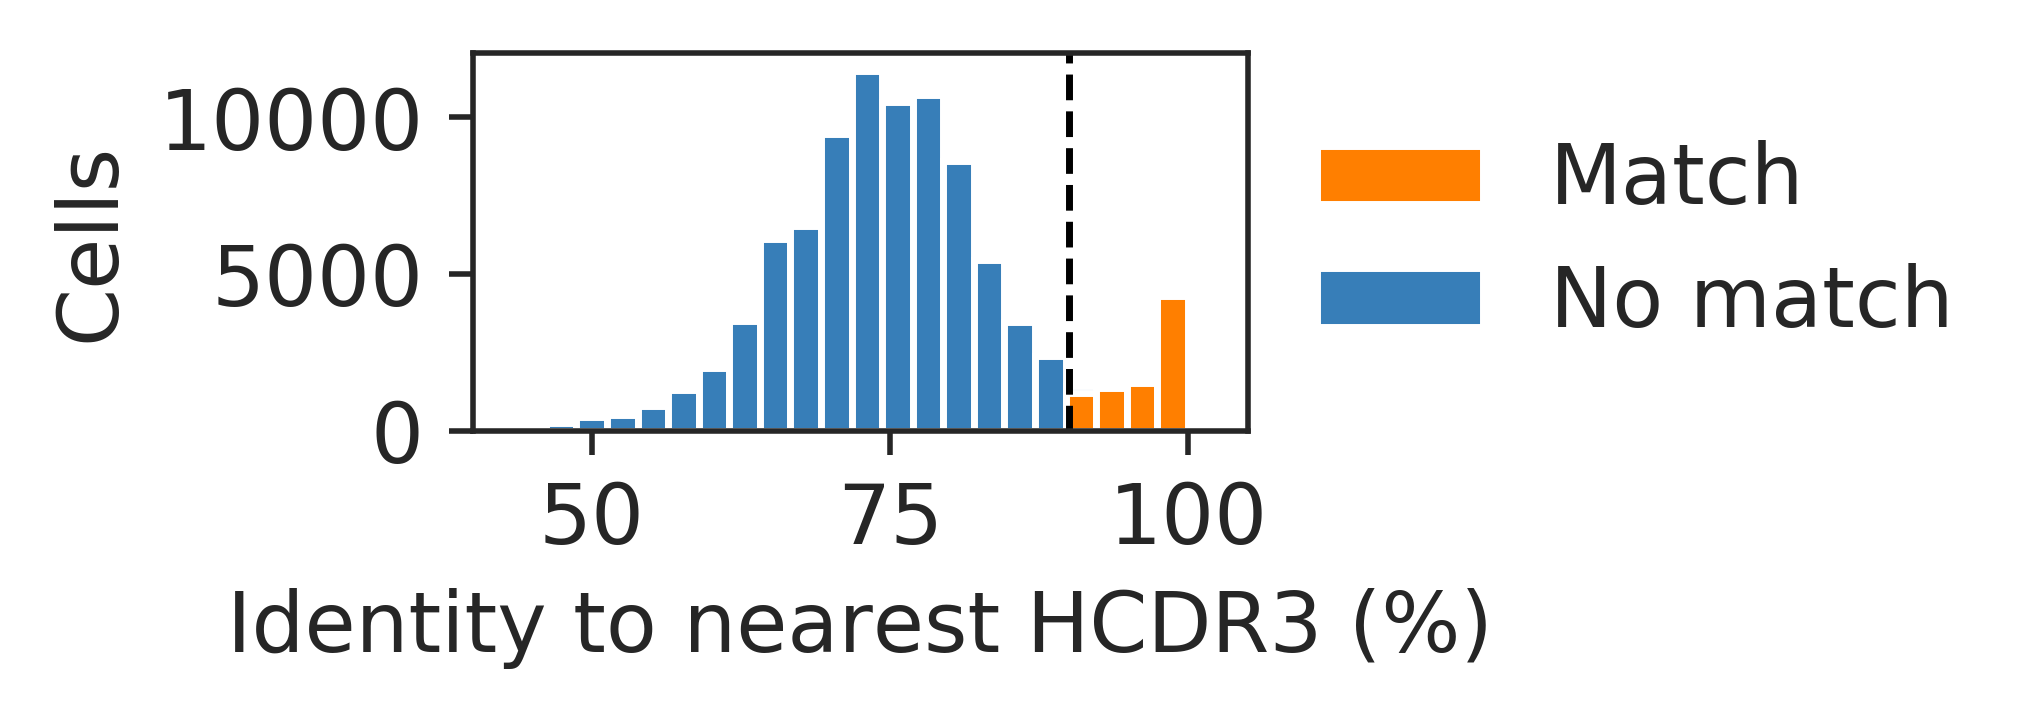

In [33]:
# Identity to nearest CDR3

x1 = np.array(cells_mapping["subject_identity_CDR3"]) * 100
x2 = np.array(cells_mapping_matches["subject_identity_CDR3"]) * 100
bins = np.linspace(0, 100, 40)

fig, ax = plt.subplots(1, 1, figsize=(2,1))
ax.hist(x2, bins=bins, label="Match", zorder=2, color="#ff7f00")
ax.hist(x1, bins=bins, label="No match", zorder=1, color="#377eb8")
ax.set_xlabel("Identity to nearest HCDR3 (%)")
ax.set_ylabel("Cells")
ax.set_yticks([0, 5000, 10000])
ax.axvline(90, ls="--", color="k", lw=1)
ax.set_xlim(left=40)
ax.legend(loc="center", bbox_to_anchor=(1.5, 0.5), frameon=False)

print np.nanmean(x1)
print np.nanstd(x1)

print np.nanmean(x2)
print np.nanstd(x2)

print len(x2) / float(len(x1) + len(x2))

save_figure(fig, "map_identity_nearest_CDR3")

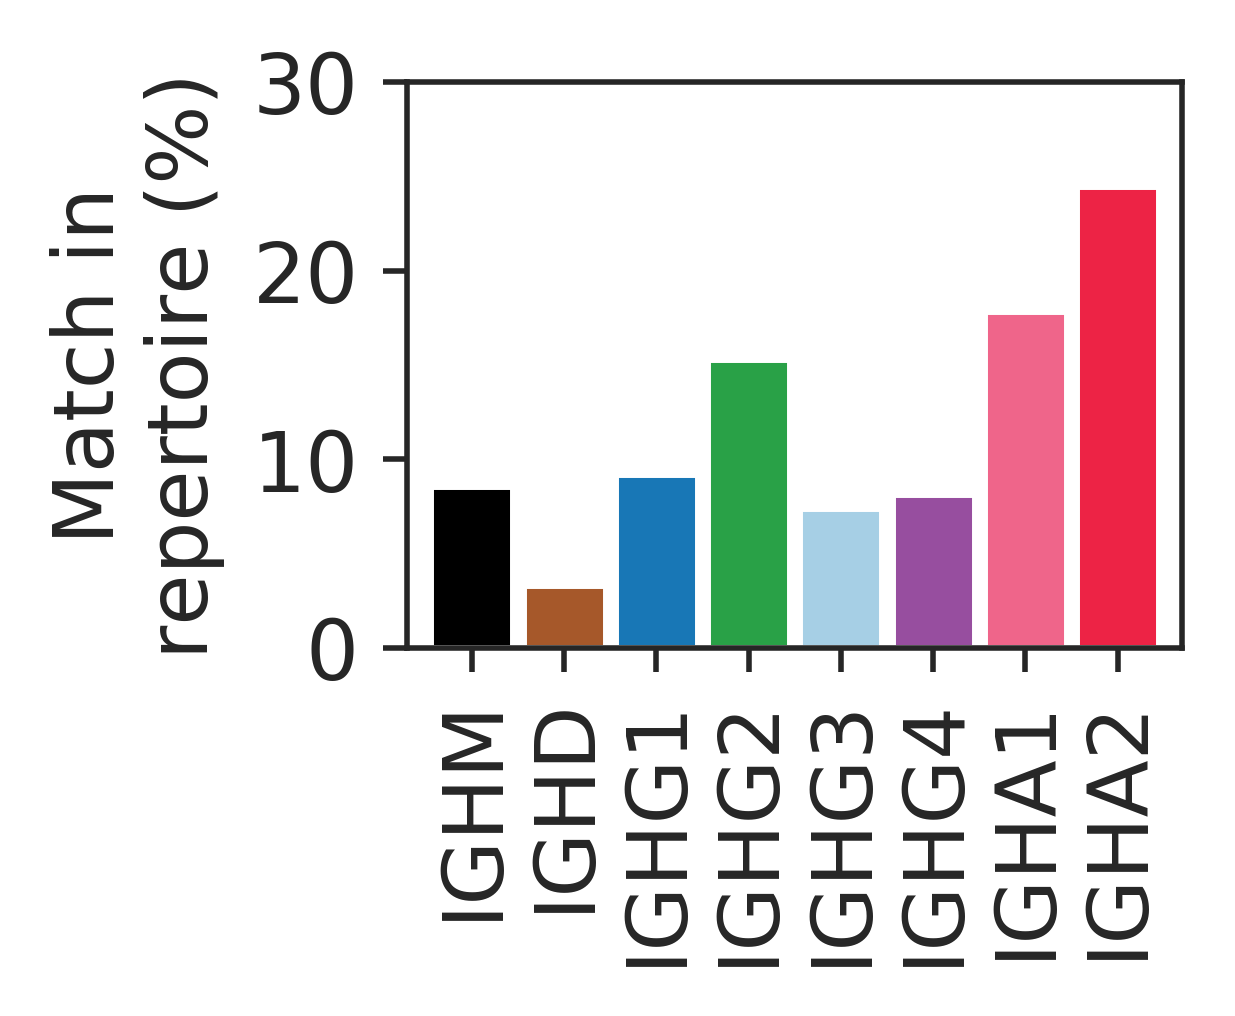

In [34]:
# Mapping rate as a function of isotype

isotypes_ordered = ["IGHM", "IGHD", "IGHG1", "IGHG2", "IGHG3", "IGHG4", "IGHA1", "IGHA2"]

x = cells_mapping.groupby("c_gene")["subject_is_hit"].value_counts(normalize=True).drop("None").xs(True, level="subject_is_hit") * 100
x = x.loc[isotypes_ordered]

# Classic color scheme from Horns et al. PNAS 2019
isotype_to_color = {"IGHM": "#000000", 
                    "IGHD": "#a6582a",
                    "IGHG1": "#1877b6",
                    "IGHG2": "#29a147",
                    "IGHG3": "#a6cfe5",
                    "IGHG4": "#974e9f",
                    "IGHA1": "#ef658a",
                    "IGHA2": "#ed2345",
                    "IGHE": "#d4c073",
                    "Not detected": "#999999"}

color = [isotype_to_color[i] for i in isotypes_ordered]

fig, ax = plt.subplots(1, 1, figsize=(2,1.5))
x.plot(kind="bar", ax=ax, width=0.9, color=color)
ax.set_xlabel("")
ax.set_ylabel("Match in\nrepertoire (%)")
ax.set_ylim(0, 30)

save_figure(fig, "map_rate_isotype")

# Fidelity of mapping: rate of light chain discordance within clonal lineages

In [36]:
# Load contigs with annotations (to get heavy-light chain contigs for each)
infile = data_dir + "all_contig_annotations.valid.csv"
contig_annotations = pd.read_csv(infile, header=0)
print contig_annotations.shape
contig_annotations.head()

(188518, 19)


,sample,barcode,is_cell,contig_id,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,full_length,productive,cdr3,cdr3_nt,reads,umis,raw_clonotype_id,raw_consensus_id
0,023-002_D7_Lane1,AAACCTGAGGCGCTCT-1,True,AAACCTGAGGCGCTCT-1_contig_1,True,559,IGH,IGHV1-69-2,IGHD6-19,IGHJ4,IGHM,True,True,CARGWLESNYAPSDYW,TGTGCGAGAGGGTGGCTGGAATCAAACTACGCACCCTCCGACTACTGG,11418,36,clonotype82,clonotype82_consensus_2
1,023-002_D7_Lane1,AAACCTGAGGCGCTCT-1,True,AAACCTGAGGCGCTCT-1_contig_2,True,577,IGK,IGKV3-20,None,IGKJ2,IGKC,True,True,CQQYGSSPYTF,TGTCAGCAGTATGGTAGCTCACCCTACACTTTT,7436,27,clonotype82,clonotype82_consensus_1
2,023-002_D7_Lane1,AAACCTGAGTTAACGA-1,True,AAACCTGAGTTAACGA-1_contig_3,True,641,IGH,IGHV3-74,IGHD4-23,IGHJ4,IGHA2,True,True,CTSHINWRWDYW,TGCACAAGCCACATAAATTGGCGGTGGGACTACTGG,363,1,clonotype83,clonotype83_consensus_2
3,023-002_D7_Lane1,AAACCTGAGTTAACGA-1,True,AAACCTGAGTTAACGA-1_contig_5,True,642,IGL,IGLV2-14,None,IGLJ1,IGLC1,True,True,CGSFTTGGADVF,TGCGGCTCATTCACAACAGGTGGCGCGGATGTCTTC,3494,26,clonotype83,clonotype83_consensus_1
4,023-002_D7_Lane1,AAACCTGCAAAGTCAA-1,True,AAACCTGCAAAGTCAA-1_contig_1,True,587,IGH,IGHV4-61,IGHD3-22,IGHJ3,IGHM,True,True,CARGGRYDSSGYHDRRGFYQYGMDVW,TGTGCGAGAGGGGGCCGGTATGATAGTAGTGGTTATCACGACCGAA...,1590,4,clonotype84,clonotype84_consensus_2


In [37]:
# Identify light chain contigs for each cell, annotate cells with lineage label
contig_annotations_temp = contig_annotations.set_index(["sample", "barcode"]).loc[zip(cells_mapping_matches["sample"], cells_mapping_matches["barcode"])] # select cells with matches in repertoire sequencing
contig_annotations_temp = contig_annotations_temp.loc[contig_annotations_temp["chain"].isin(["IGL", "IGK"])] # select light chains
contig_annotations_temp = copy.deepcopy(contig_annotations_temp) # make a copy (before adding columns)
contig_annotations_temp["subject_lineage_uid"] = list(cells_mapping_matches["subject_lineage_uid"]) # annotate light chain contigs with lineage_uid
contig_annotations_temp.head()

is_cell                    contig_id  high_confidence  length chain    v_gene d_gene j_gene c_gene  full_length  productive          cdr3                               cdr3_nt  reads  umis raw_clonotype_id           raw_consensus_id subject_lineage_uid
sample           barcode                                                                                                                                                                                                                                                                         
023-002_D9_Lane3 AACTGGTGTACCGCTG-1     True  AACTGGTGTACCGCTG-1_contig_3             True     643   IGL  IGLV2-14   None  IGLJ3  IGLC3         True        True  CASYTSGNSWVF  TGCGCCTCATATACAAGCGGCAACAGTTGGGTGTTC   8679    36     clonotype214   clonotype214_consensus_1   20201010000019248
                 TAGTGGTCATATGGTC-1     True  TAGTGGTCATATGGTC-1_contig_1             True     576   IGK   IGKV4-1   None  IGKJ1   IGKC         True        True   CQQYYTTPWTF     TGTCAGCAATATTATACTACTCCGTGGACGTTC   6846    18    clonotype5029  clonotype5029_consensus_2   20201010000073348
                 TTCGGTCGTAGCACGA-1     True  TTCGGTCGTAGCACGA-1_contig_5             True     568   IGK  IGKV2-24   None  IGKJ1   IGKC         True        True   CMQATQFPWTF     TGCATGCAAGCTACACAATTTCCGTGGACGTTC  10954    25    clonotype5924  clonotype5924_consensus_2   20201010000045571
                 AGATCTGAGCCGCCTA-1     True  AGATCTGAGCCGCCTA-1_contig_1             True     582   IGK  IGKV3-20   None  IGKJ4   IGKC         True        True   CQQYGSSPLTF     TGTCAGCAGTATGGTAGCTCACCTCTCACTTTC   9736    21     clonotype824   clonotype824_consensus_2   20201010000061584
                 GTCTTCGTCCCTAACC-1     True  GTCTTCGTCCCTAACC-1_contig_2             True     571   IGK  IGKV1-27   None  IGKJ1   IGKC         True        True   CQKYNSAPWTF     TGTCAAAAATATAACAGTGCCCCCTGGACGTTC  12907    35    clonotype4574  clonotype4574_consensus_2   20201010000110886

Mean 84.87955613523565
STD 26.003081844156412
Median 100.0


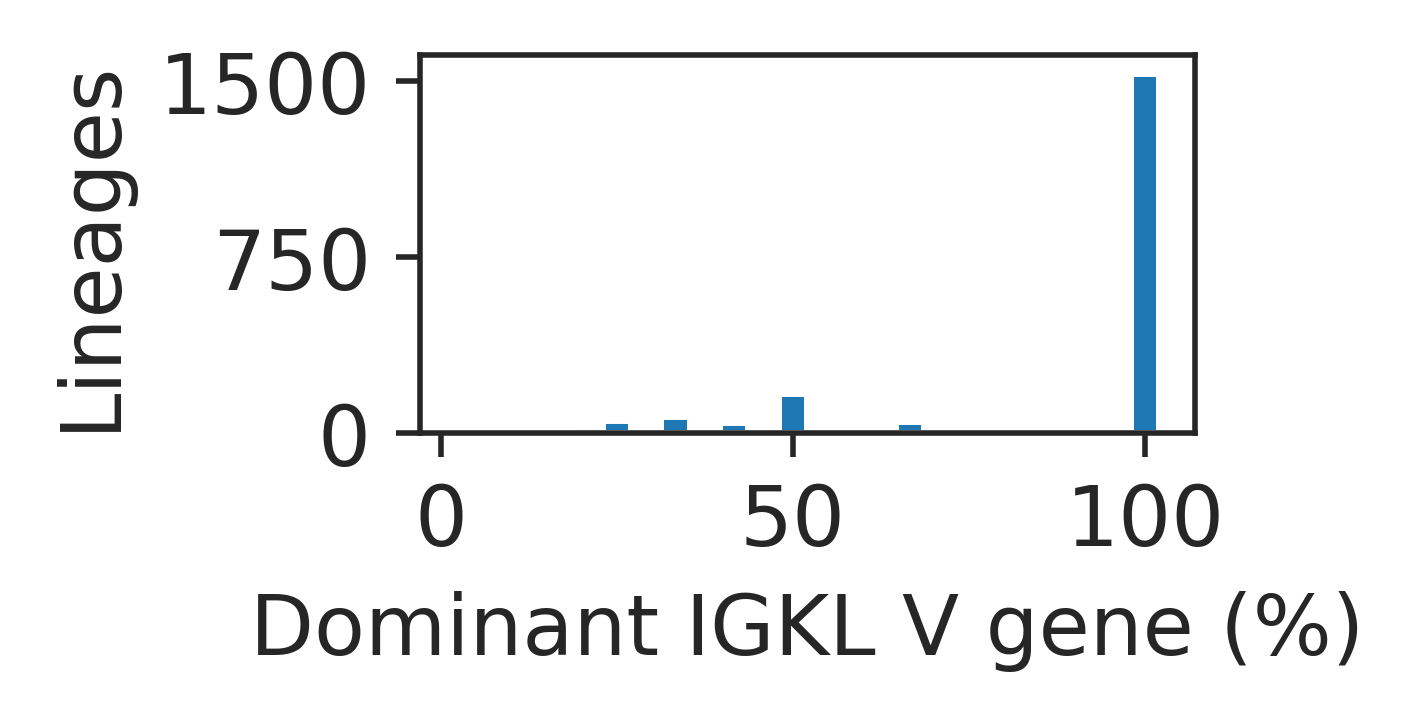

In [40]:
x = contig_annotations_temp.groupby("subject_lineage_uid")["v_gene"].value_counts(normalize=True).max(level="subject_lineage_uid")
x = x * 100 # convert to %

bins = np.linspace(0, 100, 25) + 2

fig, ax = plt.subplots(1, 1, figsize=(2,1))
ax.hist(x, bins=bins)
ax.set_yticks([0,750,1500])
ax.set_xlabel("Dominant IGKL V gene (%)")
ax.set_ylabel("Lineages")

save_figure(fig, "lineage_validation_dominant_v_gene")

print "Mean", np.mean(x)
print "STD", np.std(x)
print "Median", np.median(x)

Mean 86.63726170566511
STD 23.334105503442863
Median 100.0


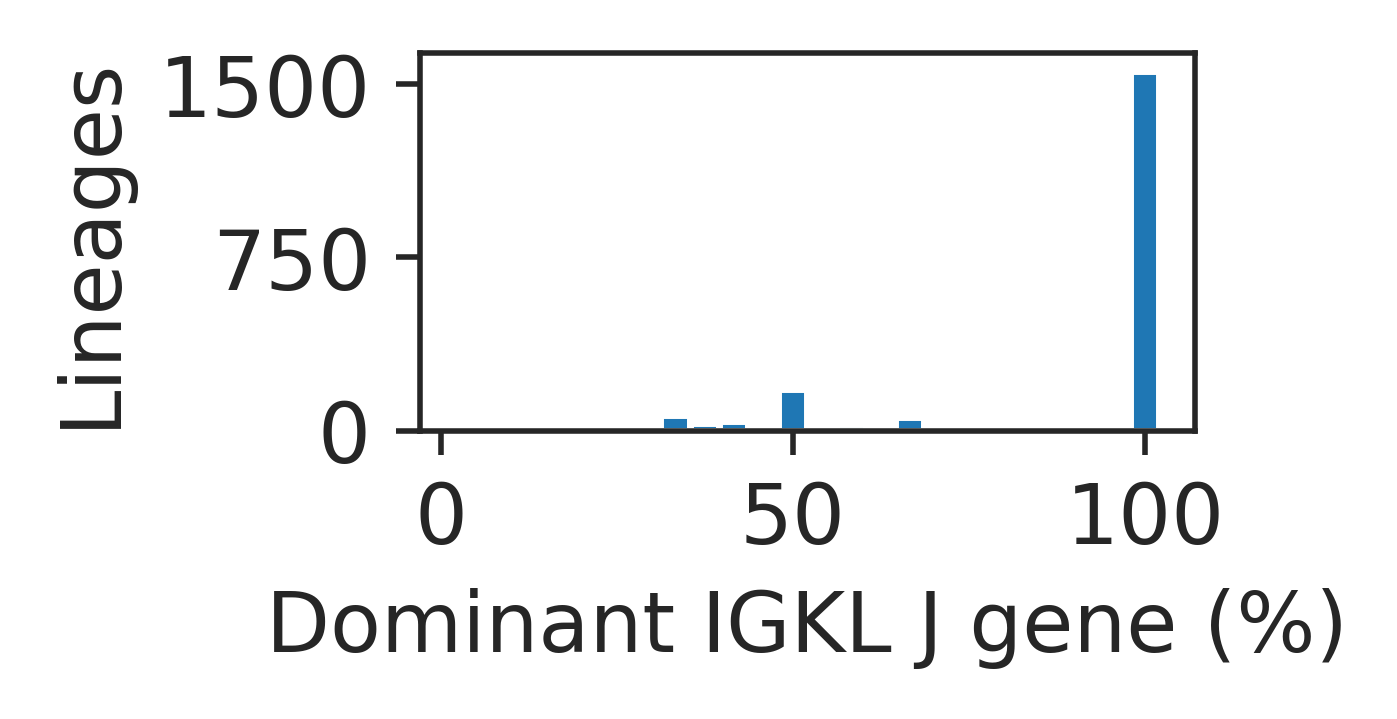

In [41]:
x = contig_annotations_temp.groupby("subject_lineage_uid")["j_gene"].value_counts(normalize=True).max(level="subject_lineage_uid")
x = x * 100 # convert to %

bins = np.linspace(0, 100, 25) + 2

fig, ax = plt.subplots(1, 1, figsize=(2,1))
ax.hist(x, bins=bins)
ax.set_yticks([0,750,1500])
ax.set_xlabel("Dominant IGKL J gene (%)")
ax.set_ylabel("Lineages")

save_figure(fig, "lineage_validation_dominant_j_gene")

print "Mean", np.mean(x)
print "STD", np.std(x)
print "Median", np.median(x)

Mean 90.45727622508407
STD 18.371279332514945
Median 100.0


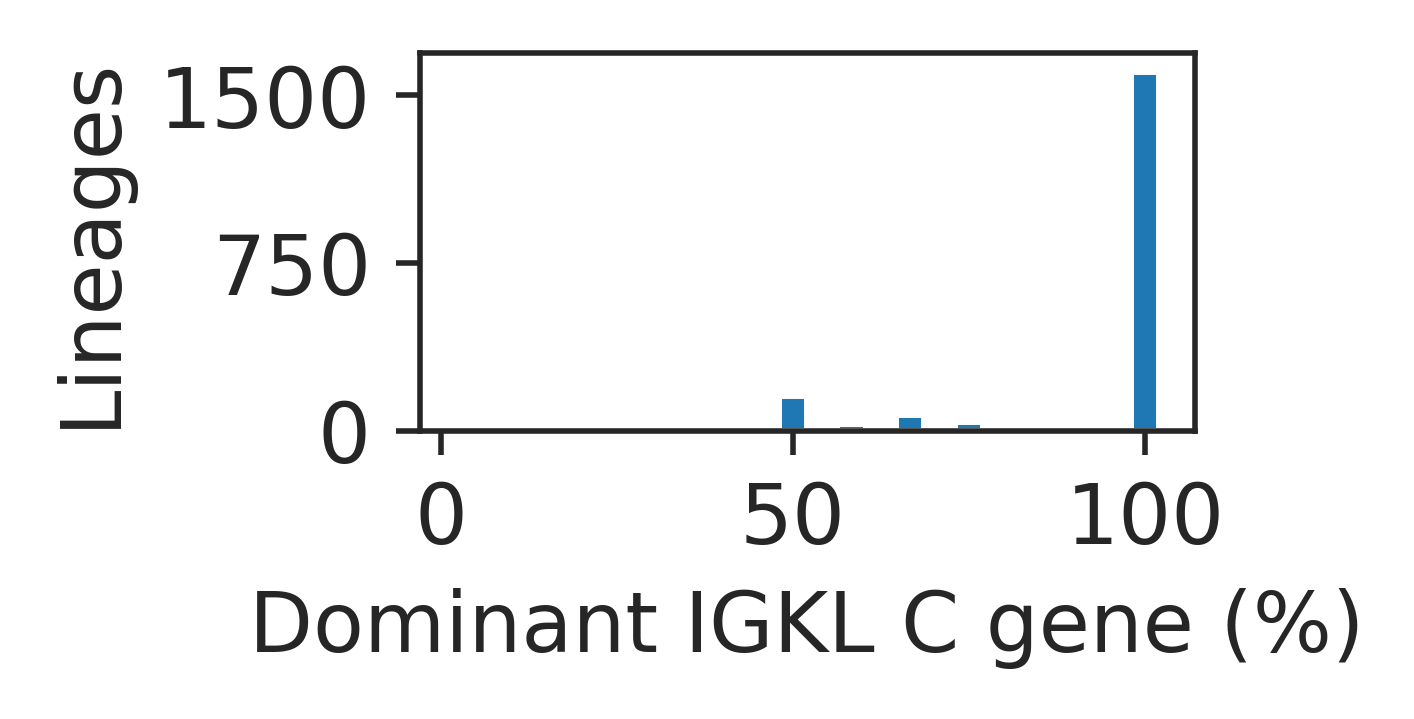

In [42]:
x = contig_annotations_temp.groupby("subject_lineage_uid")["c_gene"].value_counts(normalize=True).max(level="subject_lineage_uid")
x = x * 100 # convert to %

bins = np.linspace(0, 100, 25) + 2

fig, ax = plt.subplots(1, 1, figsize=(2,1))
ax.hist(x, bins=bins)
ax.set_yticks([0,750,1500])
ax.set_xlabel("Dominant IGKL C gene (%)")
ax.set_ylabel("Lineages")

save_figure(fig, "lineage_validation_dominant_c_gene")

print "Mean", np.mean(x)
print "STD", np.std(x)
print "Median", np.median(x)

In [48]:
# Calculate CDR3 length
contig_annotations_temp["len_cdr3"] = contig_annotations_temp["cdr3"].str.len()

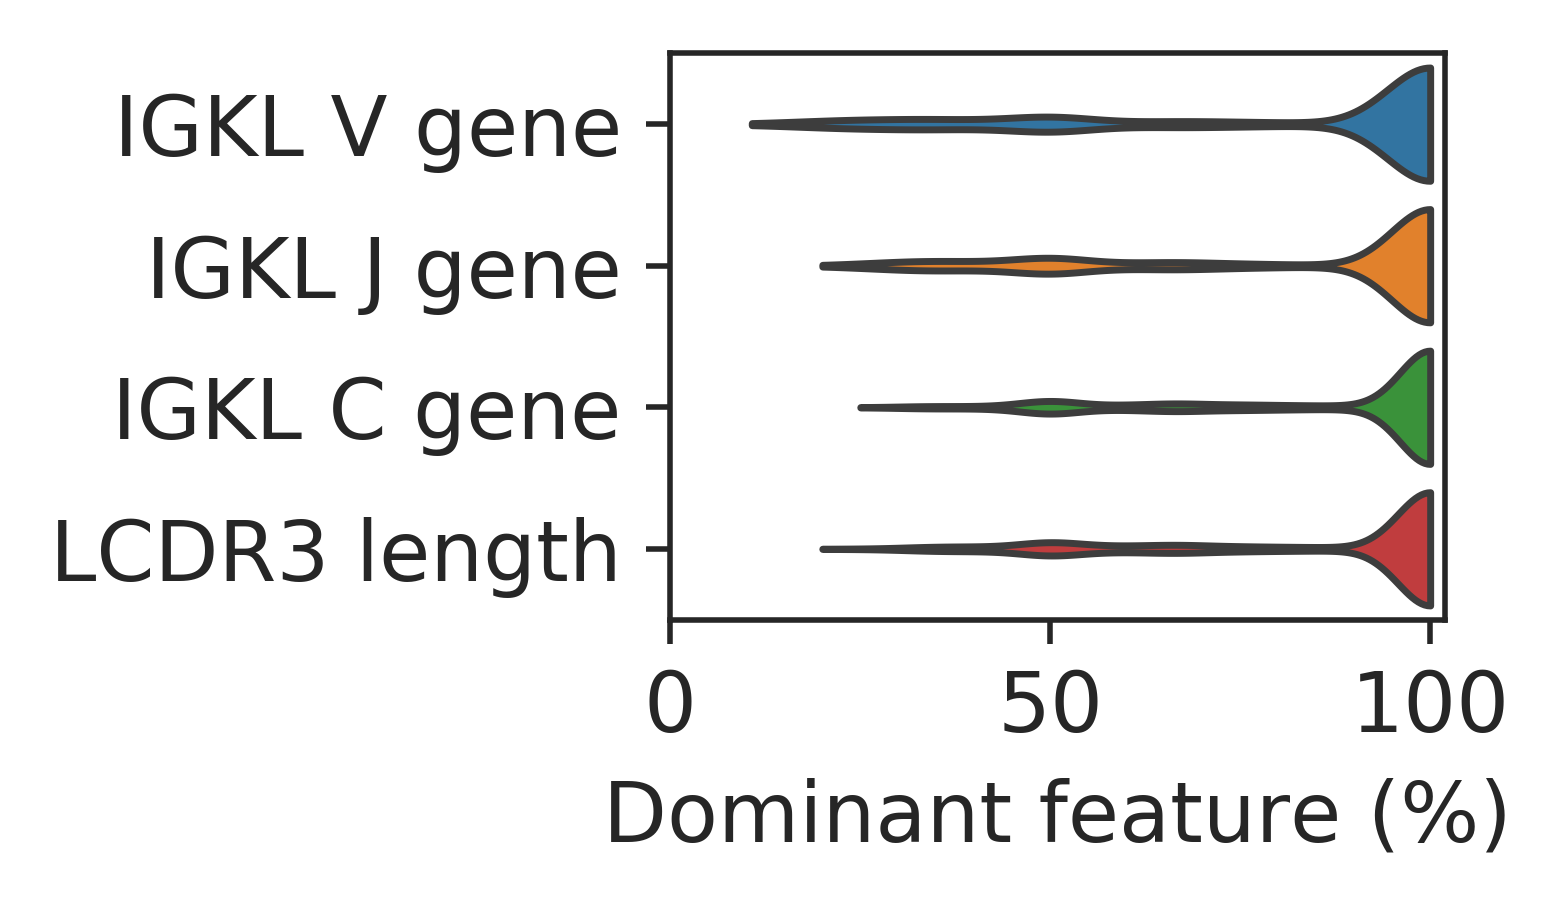

In [49]:
# Plot all dominant features on single violin

x1 = contig_annotations_temp.groupby("subject_lineage_uid")["v_gene"].value_counts(normalize=True).max(level="subject_lineage_uid") * 100
x2 = contig_annotations_temp.groupby("subject_lineage_uid")["j_gene"].value_counts(normalize=True).max(level="subject_lineage_uid") * 100
x3 = contig_annotations_temp.groupby("subject_lineage_uid")["c_gene"].value_counts(normalize=True).max(level="subject_lineage_uid") * 100
x4 = contig_annotations_temp.groupby("subject_lineage_uid")["len_cdr3"].value_counts(normalize=True).max(level="subject_lineage_uid") * 100

fig, ax = plt.subplots(1, 1, figsize=(2, 1.5))
sns.violinplot(data=[x1, x2, x3, x4], ax=ax, orient="h", width=0.8, linewidth=1, inner=None, cut=0, scale="width", gridsize=200)
ax.set_xlim(0, 102)
ax.set_xlabel("Dominant feature (%)")
yticklabels = ["IGKL V gene", "IGKL J gene", "IGKL C gene", "LCDR3 length"]
ax.set_yticklabels(yticklabels)

save_figure(fig, "lineage_validation_dominant_violin")

In [53]:
# Number of impure dominant features per lineage
x1 = contig_annotations_temp.groupby("subject_lineage_uid")["v_gene"].value_counts(normalize=True).max(level="subject_lineage_uid")
x2 = contig_annotations_temp.groupby("subject_lineage_uid")["j_gene"].value_counts(normalize=True).max(level="subject_lineage_uid")
x3 = contig_annotations_temp.groupby("subject_lineage_uid")["c_gene"].value_counts(normalize=True).max(level="subject_lineage_uid")
x4 = contig_annotations_temp.groupby("subject_lineage_uid")["len_cdr3"].value_counts(normalize=True).max(level="subject_lineage_uid")
X = np.array([x1, x2, x3, x4])
z = np.sum(X < 0.8, axis=0)

In [54]:
# Examine features of impure lineages
lineage_uids_impure = contig_annotations_temp.groupby("subject_lineage_uid")["len_cdr3"].value_counts().index.get_level_values("subject_lineage_uid").drop_duplicates()[z==4] # get labels of impure lineages

# Make a copy of dataframe
cells_mapping_matches_temp = copy.deepcopy(cells_mapping_matches)

# Annotate lineages by purity
cells_mapping_matches_temp["purity"] = ""
cells_mapping_matches_temp["purity"].loc[cells_mapping_matches_temp["subject_lineage_uid"].isin(lineage_uids_impure)] = "Impure"
cells_mapping_matches_temp["purity"].loc[~cells_mapping_matches_temp["subject_lineage_uid"].isin(lineage_uids_impure)] = "Pure"

# Calculate HCDR3 length
cells_mapping_matches_temp["len_cdr3"] = [len(x) for x in cells_mapping_matches_temp["cdr3"]]

cells_mapping_matches_temp.head()

,sample,barcode,is_cell,contig_id,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,full_length,productive,cdr3,cdr3_nt,reads,umis,raw_clonotype_id,raw_consensus_id,len_CDR3_adj,seq_before_CDR3,seq_CDR3_adj,seq_after_CDR3,num_hits,subject_seq_id,subject_lineage_uid,subject_lineage_num_unique_seqs,subject_lineage_num_molecules,subject_V_gene,subject_D_gene,subject_J_gene,subject_isotype,subject_abundance,subject_V_seq,subject_D_seq,subject_J_seq,subject_C_seq,subject_identity_CDR3,subject_identity_non_CDR3,subject_identity_V,subject_identity_J,subject_is_hit,subject2_seq_id,subject2_lineage_uid,subject2_lineage_num_unique_seqs,subject2_lineage_num_molecules,subject2_V_gene,subject2_D_gene,subject2_J_gene,subject2_isotype,subject2_abundance,subject2_V_seq,subject2_D_seq,subject2_J_seq,subject2_C_seq,subject2_identity_CDR3,subject2_identity_non_CDR3,subject2_identity_V,subject2_identity_J,subject2_is_hit,purity,len_cdr3
0,023-002_D9_Lane3,AACTGGTGTACCGCTG-1,True,AACTGGTGTACCGCTG-1_contig_1,True,507,IGH,IGHV2-70,IGHD2-15,IGHJ4,IGHM,True,True,CARISWWDFDSW,TGTGCACGAATCTCGTGGTGGGACTTTGATTCCTGG,7629,8,clonotype214,clonotype214_consensus_2,29,TGGGAGTGAATCCTGCTCTCCACCATGGACATACTTTGGTCCACGC...,GCACGAATCTCGTGGTGGGACTTTGATTC,CTGGGGCCAGGGAACCCCGGTCATCGTCTCCTCAGGGAGTGCATCC...,21,20502010100032723,20201010000019248,617.0,3281.0,IGHV2-70*01,IGHD2-15*01,IGHJ4*02,IgM,4,AGGTGGTCCTTACAATGACCAACATGGACCCTGTGGACACAGCCAC...,GCACGGATCTCGTGGTGGGACTTTGATTC,CTGGGGCCAGGGAACCCTGGTCACCGTCTCCTCA,GGGAGTGCATCCGCCCCAACCCTTTTCCCCCTCGTCTCCTGTGAGA...,0.965517,0.933333,0.928571,0.941176,True,20302010100060507,20201010000019248,617.0,3281.0,IGHV2-70*01,IGHD2-15*01,IGHJ4*02,IgM,2,AGGTGGTCCTTACAATGACCAACATGGACCCTGTGGACACAGCCAC...,GCACGAATCTCGTGGTGGGACTTTGACTC,CTGGGGCCAGGGAATCCTGGTCACCGTCTCCTCA,GGGAGTGCATCCGCCCCAACCCTTTTCCCCCTCGTCTCCTGTGAGA...,0.965517,0.922222,0.928571,0.911765,True,Impure,12
37,023-002_D9_Lane3,TAGTGGTCATATGGTC-1,True,TAGTGGTCATATGGTC-1_contig_2,True,685,IGH,IGHV3-73,IGHD3-10,IGHJ4,IGHA1,True,True,CTSSGVINVNFDYW,TGTACTAGCTCGGGAGTTATTAATGTGAACTTTGACTACTGG,3082,7,clonotype5029,clonotype5029_consensus_1,35,GAAGCAGCCCAGCCCTGACCCTGCAGCTCTGGGAGAGGAGCTCCAG...,ACTAGCTCGGGAGTTATTAATGTGAACTTTGACTA,CTGGGGCCAGGGAACCCTGGTCACCGTCTCCTCAGCATCCCCGACC...,1,20502010100054132,20201010000073348,660.0,2364.0,IGHV3-73*01,IGHD3-10*01,IGHJ4*02,IgM,4,TCTGCAAATGAACAGCCTGAAAACCGAGGACACGGCCGTGTATTATTGT,ACTAGCTCGGGAGTTATTAAAGTGAATTTTGACTA,CTGGGGCCAGGGAACCCTGGTCACCGTCTCCTCA,GGGAGTGCATCCGCCCCAACCCTTTTCCCCCTCGTCTCCTGTGAGA...,0.942857,1.000000,1.000000,1.000000,True,29902010100988707,20201010000073348,660.0,2364.0,IGHV3-73*01,IGHD4-17*01,IGHJ4*02,IgM,2,GGTGGAGTCTGGGGGAGGCTTGGTCCAGCCTGGGGGGTCCCTGAGA...,ACTAGACGGAGTGACTACGGTGACCACCTTGACTA,CTGGGGCCAGGGAACCCTGGTCACCGTCTCCTCA,GGGAGTGCATCCGCCCCAACCCTTTTCCCCCTCGTCTCCTGTGAGA...,0.714286,0.996845,0.996466,1.000000,False,Pure,14
41,023-002_D9_Lane3,TTCGGTCGTAGCACGA-1,True,TTCGGTCGTAGCACGA-1_contig_3,True,555,IGH,IGHV5-51,IGHD5-18,IGHJ5,IGHM,True,True,CATADTTMNYWFDPW,TGTGCGACGGCGGATACAACTATGAATTACTGGTTCGACCCCTGG,21262,36,clonotype5924,clonotype5924_consensus_1,38,GGGACAGTGAGTCTCCCTCACTGCCCAGCTGGGATCTCAGGGCTTC...,GCGACGGCGGATACAACTATGAATTACTGGTTCGACCC,CTGGGGCCAGGGAACCCTGGTCATTGTCGACTCAGGGAGTGCATCC...,1,29902010100089606,20201010000045571,97.0,475.0,IGHV5-51*03,IGHD5-18*01,IGHJ5*02,IgM,1,GGTGGAGTCTGGAGTAGAGGTGAAAAAGCCGGGGGAGTCACTGAAG...,GCGACGGCGGATACAACTATGAATTATTGGTTCGACCC,CTGGGGCCAGGGAACCCTGGTC,ATTGTCGACTCAGGGAGTGCATCCGCCCCAACCCTTTTCCCCCTCG...,0.973684,0.976589,0.974729,1.000000,True,29902010101014381,20201010000045571,97.0,475.0,IGHV5-51*03,IGHD3-3*01,IGHJ5*02,IgM,1,TGCAGTCTGGAGCAGAGGTGAAAAAGCCGGGGGAGTCTCTGAAGAT...,GCGAGCGGTGGATCAAATGACTACGAGTGGTTCGACCC,CTGGGGCCAGGGAACCCTGGTCACCGTCTCCTCA,GGGAGTGCATCCGCCCCAACCCTTTTCCCCCTCGTCTCCTGTGAGA...,0.736842,0.951456,0.960000,0.882353,False,Pure,15
56,023-002_D9_Lane3,AGATCTGAGCCGCCTA-1,True,AGATCTGAGCCGCCTA-1_contig_4,True,579,IGH,IGHV3-23,None,IGHJ6,IGHM,True,True,CAKRDYYYGMDVW,TGTGCGAAACGCGACTACT

In [55]:
# Summarize features

for feature in ["len_cdr3", "j_gene", "v_gene"]:
    print cells_mapping_matches_temp.groupby("purity")[feature].value_counts(normalize=True)

# Impure lineages tend towards:
# Short CDR3
# IGHJ4 usage


purity  len_cdr3
Impure  13          0.189572
        14          0.142480
        15          0.133109
        16          0.097549
        17          0.094906
        12          0.093224
        18          0.065113
        11          0.055022
        19          0.037001
        20          0.030754
        10          0.026189
        21          0.012254
        22          0.006728
        8           0.004565
        9           0.004565
        7           0.003844
        24          0.001682
        23          0.001442
Pure    16          0.131435
        17          0.101542
        19          0.092764
        13          0.091815
        15          0.079004
        18          0.077580
        14          0.069751
        20          0.055042
        21          0.053855
        11          0.051720
        10          0.045077
        12          0.034401
        22          0.031554
        23          0.020878
        9           0.014235
        24          0.0125

16.0
14.0
MannwhitneyuResult(statistic=6544369.0, pvalue=3.791665478986292e-91)


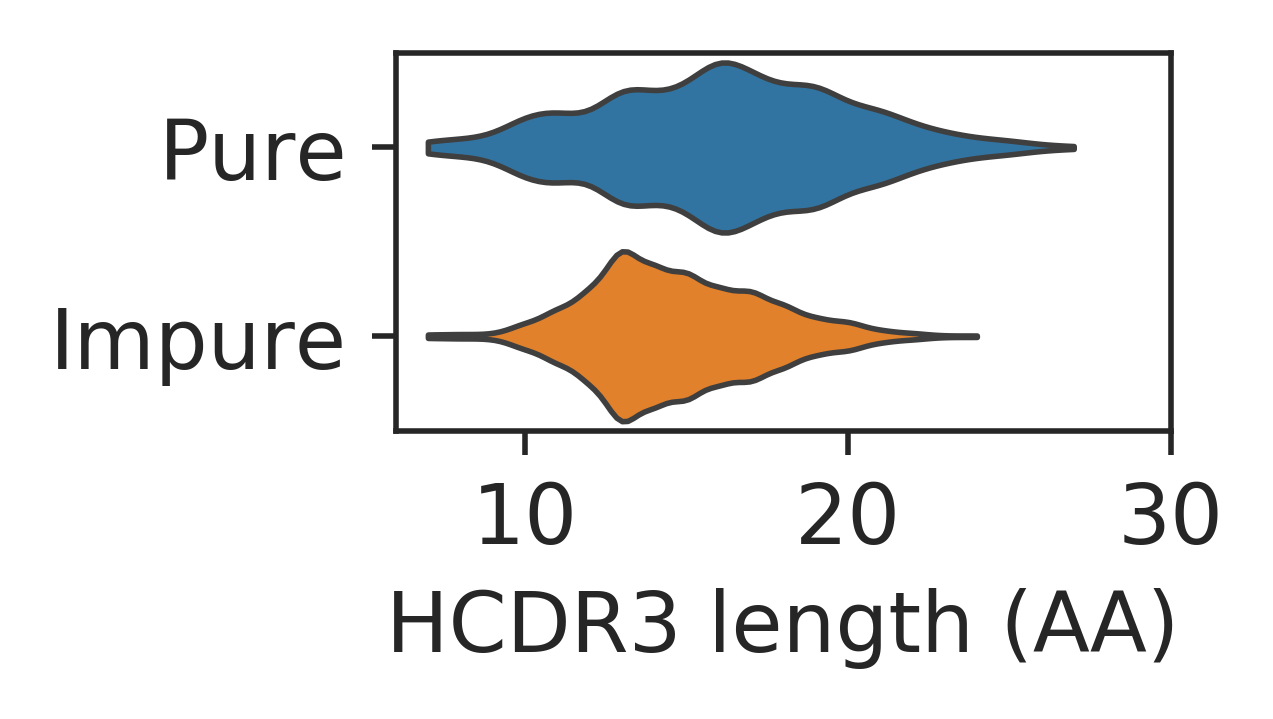

In [56]:
x = cells_mapping_matches_temp[["purity", "len_cdr3"]]
x1 = x.loc[x["purity"] == "Pure"]["len_cdr3"]
x2 = x.loc[x["purity"] == "Impure"]["len_cdr3"]
data = [x1, x2]

fig, ax = plt.subplots(1, 1, figsize=(2,1))
sns.violinplot(data=data, ax=ax, orient="h", cut=0, scale="width", width=0.9, linewidth=0.8, inner=None)
ax.set_xlabel("HCDR3 length (AA)")
ax.set_yticklabels(["Pure", "Impure"])
ax.set_xticks([10, 20, 30])

save_figure(fig, "lineage_validation_purity_len_cdr3")

print np.median(x1)
print np.median(x2)
print scipy.stats.mannwhitneyu(x1, x2)

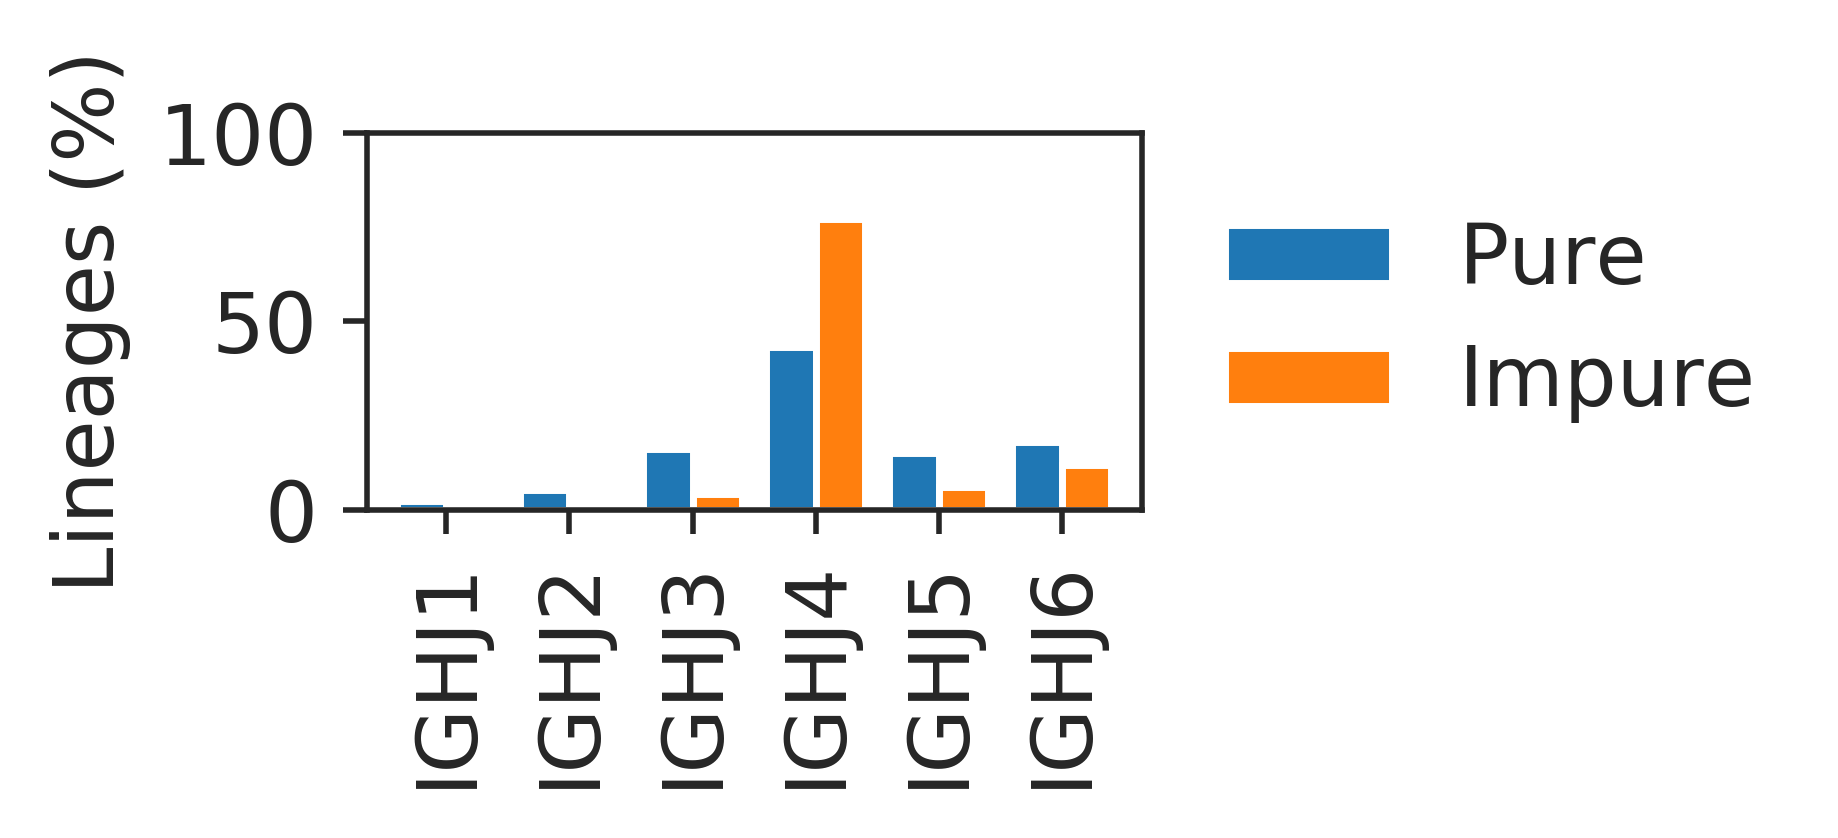

In [57]:
x1 = cells_mapping_matches_temp.loc[cells_mapping_matches_temp["purity"] == "Pure"]["j_gene"].value_counts(normalize=True)
x2 = cells_mapping_matches_temp.loc[cells_mapping_matches_temp["purity"] == "Impure"]["j_gene"].value_counts(normalize=True)
data = pd.DataFrame({"Pure": x1, "Impure": x2})

fig, ax = plt.subplots(1, 1, figsize=(2,1))
data[["Pure", "Impure"]].plot(kind="bar", ax=ax, width=0.8)
ax.set_ylim(0,1)
ax.set_yticklabels([0, 50, 100])
ax.set_ylabel("Lineages (%)")
ax.legend(loc="center", bbox_to_anchor=(1.45, 0.5), frameon=False)

save_figure(fig, "lineage_validation_purity_j_gene")

In [58]:
# Statistical test

x1 = cells_mapping_matches_temp.loc[cells_mapping_matches_temp["purity"] == "Pure"]["j_gene"].value_counts(normalize=False)
x2 = cells_mapping_matches_temp.loc[cells_mapping_matches_temp["purity"] == "Impure"]["j_gene"].value_counts(normalize=False)
data = pd.DataFrame({"Pure": x1, "Impure": x2})

print "IGHJ4"
print data.loc["IGHJ4"]
print data.loc["IGHJ4"] / sum(data.loc["IGHJ4"])
print
print "Not IGHJ4"
print data.loc[set(list(data.index)) - set(["IGHJ4"])].sum()
print (data.loc[set(list(data.index)) - set(["IGHJ4"])].sum()) / sum(data.loc[set(list(data.index)) - set(["IGHJ4"])].sum())
print

print scipy.stats.fisher_exact([[3206, 1816], [956, 2399]])

IGHJ4
Impure    3206
Pure      1816
Name: IGHJ4, dtype: int64
Impure    0.638391
Pure      0.361609
Name: IGHJ4, dtype: float64

Not IGHJ4
Impure     956
Pure      2399
dtype: int64
Impure    0.284948
Pure      0.715052
dtype: float64

(4.4301663041675114, 5.099025277326816e-226)
